# Strong Lensing Classification with Multi-class Logistic Regression

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 8 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of binary classification through logistic regression, we developed the mathematical framework for distinguishing between two classes using the sigmoid function and gradient descent optimization. We now extend these concepts to multi-class classification, where we must distinguish among many categories—a scenario that frequently arises in astronomical applications.

This tutorial explores multi-class logistic regression through one of astronomy's most visually striking phenomena: strong gravitational lensing. When light from a distant galaxy passes near a massive foreground object, general relativity predicts that spacetime curvature will bend the light's path. In cases of perfect alignment and sufficient mass, this bending creates dramatic effects—multiple images of the background source, elongated arcs tracing Einstein radii, or even complete rings of light.

Strong gravitational lensing serves as both a spectacular confirmation of Einstein's theory and a powerful astrophysical tool. These cosmic lenses allow us to:
- Map the dark matter distribution in galaxy clusters through their gravitational effects
- Study galaxies in the early universe, magnified by factors of 10-100
- Measure cosmological parameters, particularly through time delays between multiple images
- Test alternative theories of gravity at cosmological scales

The James Webb Space Telescope has revolutionized strong lensing studies. Its unprecedented infrared sensitivity and spatial resolution reveal intricate details in lensed galaxies, including star-forming regions and morphological features that would otherwise be invisible. JWST observations have uncovered lensed galaxies at redshifts exceeding 10, providing windows into the universe's first billion years.

However, the richness of JWST data presents a classification challenge. A single deep field might contain dozens of lensing features—arcs of varying curvature, multiple images with different configurations, partial Einstein rings, and galaxy-galaxy lenses. Manual classification becomes impractical for large surveys. This motivates our development of automated classification methods that can distinguish between different types of lensing features and non-lensed objects.

Through this tutorial, we'll build a complete multi-class classification pipeline. Starting from raw JWST images, we'll extract meaningful features using modern computer vision techniques, implement the softmax generalization of logistic regression, and develop optimization algorithms for multi-class problems. The mathematical progression from binary to multi-class classification illuminates how machine learning concepts generalize to handle increasing complexity while maintaining computational tractability.



## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial builds upon the concepts introduced in Chapters 7 and 8. You should be comfortable with:
- **Binary Logistic Regression**: Understanding the sigmoid function, log-odds, and gradient descent optimization
- **Cross-Entropy Loss**: The probabilistic interpretation of classification loss functions
- **Gradient Computation**: Deriving and implementing gradients for optimization
- **NumPy Operations**: Matrix multiplication, broadcasting, and efficient array manipulation
- **Python Programming**: Object-oriented design and vectorized computations

### Learning Outcomes

Through this tutorial, you will master:
- **Multi-class Classification Theory**: Extending binary classification to multiple categories through the softmax function and multi-class cross-entropy loss
- **Feature Extraction from Images**: Using pre-trained neural networks to convert high-dimensional image data into meaningful numerical representations
- **Softmax Implementation**: Building numerically stable implementations of the softmax function for probability normalization across classes
- **Gradient-Based Optimization**: Implementing stochastic gradient descent with mini-batching for large-scale classification problems
- **Model Evaluation**: Constructing and interpreting confusion matrices, calculating per-class accuracies, and identifying systematic misclassification patterns
- **Hyperparameter Optimization**: Systematic exploration of learning rates and regularization strengths to optimize model performance

These skills form the foundation for modern astronomical classification pipelines, where automated systems must reliably categorize diverse phenomena from massive surveys. The techniques we develop here extend naturally to any multi-class problem, from classifying variable star types to identifying galaxy morphologies.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pickle

# Configure plotting parameters to match textbook style
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## James Webb Space Telescope: A New Window on Strong Lensing

The James Webb Space Telescope represents a quantum leap in our ability to study gravitational lensing systems. With its 6.5-meter segmented primary mirror and suite of infrared instruments, JWST achieves angular resolutions of ~0.1 arcseconds in the near-infrared—sufficient to resolve individual star-forming regions in lensed galaxies at cosmic noon.

Strong gravitational lensing occurs when a massive foreground object (the lens) lies almost perfectly aligned with a more distant source along our line of sight. The lens's gravity bends spacetime, creating multiple light paths from source to observer. Depending on the geometry, we observe:

- **Multiple Images**: The same background galaxy appears at different positions, each following a different light path around the lens
- **Giant Arcs**: Extended sources are stretched into luminous arcs tracing portions of the Einstein radius
- **Einstein Rings**: Perfect alignment produces a complete ring of light—nature's demonstration of cylindrical symmetry in gravitational optics
- **Radial Arcs**: Sources near the lens center create short, radially-oriented arcs pointing toward the lens center

JWST's infrared capabilities are particularly powerful for lensing studies. Observing at 1-5 microns allows us to peer through intervening dust, capture the redshifted UV and optical light from the earliest galaxies, and achieve superior resolution compared to ground-based observations affected by atmospheric turbulence.

Let's begin by examining an example of JWST's spectacular strong lensing observations:

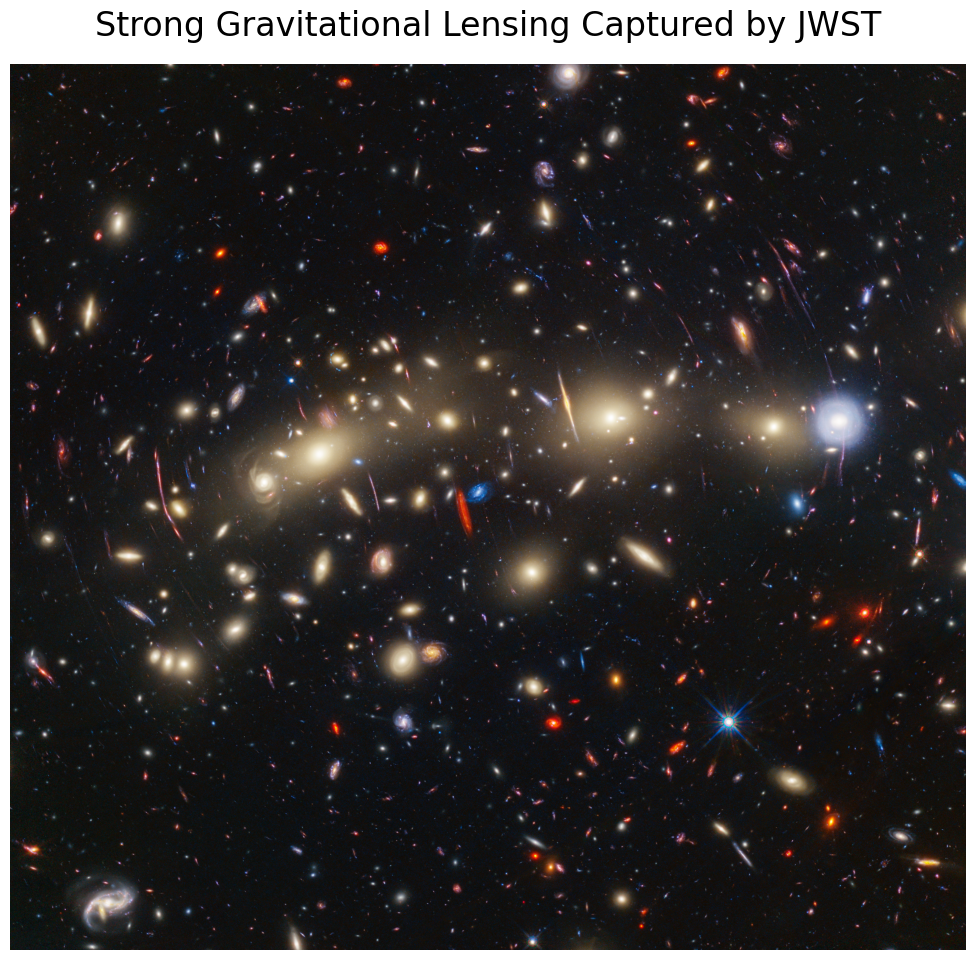

In [63]:
# Load and display a JWST strong lensing image
img = Image.open('dataset_jwst.png')

# Create figure with proper sizing
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Strong Gravitational Lensing Captured by JWST', fontsize=24, pad=20)
plt.tight_layout()
plt.show()

## Data Preparation: From Raw Images to Machine Learning Input

Raw astronomical images present unique challenges for machine learning. A single JWST deep field contains thousands of objects at varying distances, with dramatically different angular sizes, surface brightnesses, and morphologies. Strong lensing features are often embedded within complex fields containing foreground stars, background galaxies, and instrumental artifacts.

Traditional approaches required manual identification and extraction of regions of interest—a process that doesn't scale to modern surveys producing terabytes of data nightly. Modern computer vision techniques offer a solution through automated segmentation and feature extraction.

For this tutorial, we've pre-processed our JWST images using the Segment Anything Model (SAM), developed by Meta AI Research. SAM represents a breakthrough in image segmentation, trained on over 1 billion masks to identify and isolate objects across diverse domains.

For astronomical applications, SAM excels at:
- Identifying distinct lensing features such as arcs and multiple images
- Separating foreground lens galaxies from background lensed sources  
- Creating precise masks around extended, irregular objects
- Handling the high dynamic range typical of astronomical images

The segmentation process transforms a complex field into individual cutouts, each containing a potential object of interest. This preprocessing step is crucial—it converts an unstructured image analysis problem into a structured classification task where each cutout can be assigned to a category.

We've assembled a dataset of segmented objects from JWST observations, each preprocessed to ensure consistency:

- **Standardized Size**: All images resized to 64×64 pixels, balancing detail preservation with computational efficiency
- **AI-Assisted Labeling**: Initial classifications generated using vision-language models to identify lensing features
- **Multiple Annotations**: Each object includes cluster assignments, text descriptions, and gravitational arc confidence ratings
- **Quality Control**: Images selected for sufficient signal-to-noise and clear morphological features

This dataset represents a significant curation effort, transforming raw JWST observations into a machine learning-ready format. Let's load and explore this preprocessed data:

In [64]:
# Load the preprocessed strong lensing dataset
import zipfile
with zipfile.ZipFile('dataset_jwst.pkl.zip', 'r') as zip_ref:
    with zip_ref.open('dataset_jwst.pkl', 'r') as f:
        images_df = pickle.load(f)

print(f"Dataset successfully loaded!")
print(f"Total number of objects: {len(images_df)}")
print(f"\nDataset structure:")
print(f"Columns: {list(images_df.columns)}")

# Display first few entries to understand the data structure
print("\nFirst 5 entries:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
display(images_df.head())

# Convert arc ratings to numeric, handling any non-numeric values
images_df['contains_gravitational_arcs'] = pd.to_numeric(
    images_df['contains_gravitational_arcs'], 
    errors='coerce'
)

# Analyze the distribution of clusters and arc ratings
print(f"\nNumber of unique clusters: {images_df['cluster'].nunique()}")
print(f"\nDistribution of gravitational arc ratings:")

# Handle the arc distribution with the converted numeric values
arc_distribution = images_df['contains_gravitational_arcs'].value_counts().sort_index()
for rating, count in arc_distribution.items():
    if not pd.isna(rating):  # Skip NaN values if any
        print(f"  Rating {int(rating)}: {count} objects ({count/len(images_df)*100:.1f}%)")

# Check if there were any conversion issues
nan_count = images_df['contains_gravitational_arcs'].isna().sum()
if nan_count > 0:
    print(f"\nWarning: {nan_count} entries had non-numeric arc ratings and were converted to NaN")

Dataset successfully loaded!
Total number of objects: 2873

Dataset structure:
Columns: ['image_resized', 'cluster', 'concise_description', 'contains_gravitational_arcs']

First 5 entries:


image_resized  cluster  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 4], ...        0   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        0   
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        0   
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], ...        0   
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        0   

                                 concise_description  \
0  Blurry multicolored irregular galaxies at high...   
1  Blurry multicolored irregular galaxies at high...   
2  Blurry multicolored irregular galaxies at high...   
3  Blurry multicolored irregular galaxies at high...   
4  Blurry multicolored irregular galaxies at high...   

  contains_gravitational_arcs  
0                           2  
1                           2  
2                           2  
3                           2  
4                           2


Number of unique clusters: 50

Distribution of gravitational arc ratings:
  Rating 1: 1593 objects (55.4%)
  Rating 2: 667 objects (23.2%)
  Rating 3: 192 objects (6.7%)
  Rating 4: 127 objects (4.4%)
  Rating 5: 294 objects (10.2%)


Our preprocessed dataset contains several key components that enable comprehensive analysis:

**Image Data (`image_resized`)**: Each entry contains a 64×64×3 RGB image array, standardized in size to ensure consistent input dimensions for our machine learning pipeline. This preprocessing maintains the essential morphological features while enabling batch processing.

**Cluster Assignments (`cluster`)**: Objects have been grouped into 50 distinct clusters based on visual similarity. These clusters emerged from unsupervised analysis of the image features, potentially capturing different types of lensing configurations, galaxy morphologies, or image artifacts.

**Descriptive Labels (`concise_description`)**: AI-generated text descriptions provide human-readable summaries of each object's appearance. These descriptions offer insights into the visual features that distinguish different clusters.

**Gravitational Arc Confidence (`contains_gravitational_arcs`)**: A rating from 1 to 5 indicating the likelihood that an object contains gravitational arc features:
- 1: Definitely no gravitational arcs
- 2: Probably no gravitational arcs
- 3: Uncertain
- 4: Probably contains gravitational arcs
- 5: Definitely contains gravitational arcs

This multi-faceted annotation allows us to approach the classification problem from multiple angles—using the cluster assignments as our primary classification targets while leveraging the arc ratings to understand the astrophysical significance of different clusters.

Let's visualize some examples from our dataset to better understand what we're working with:

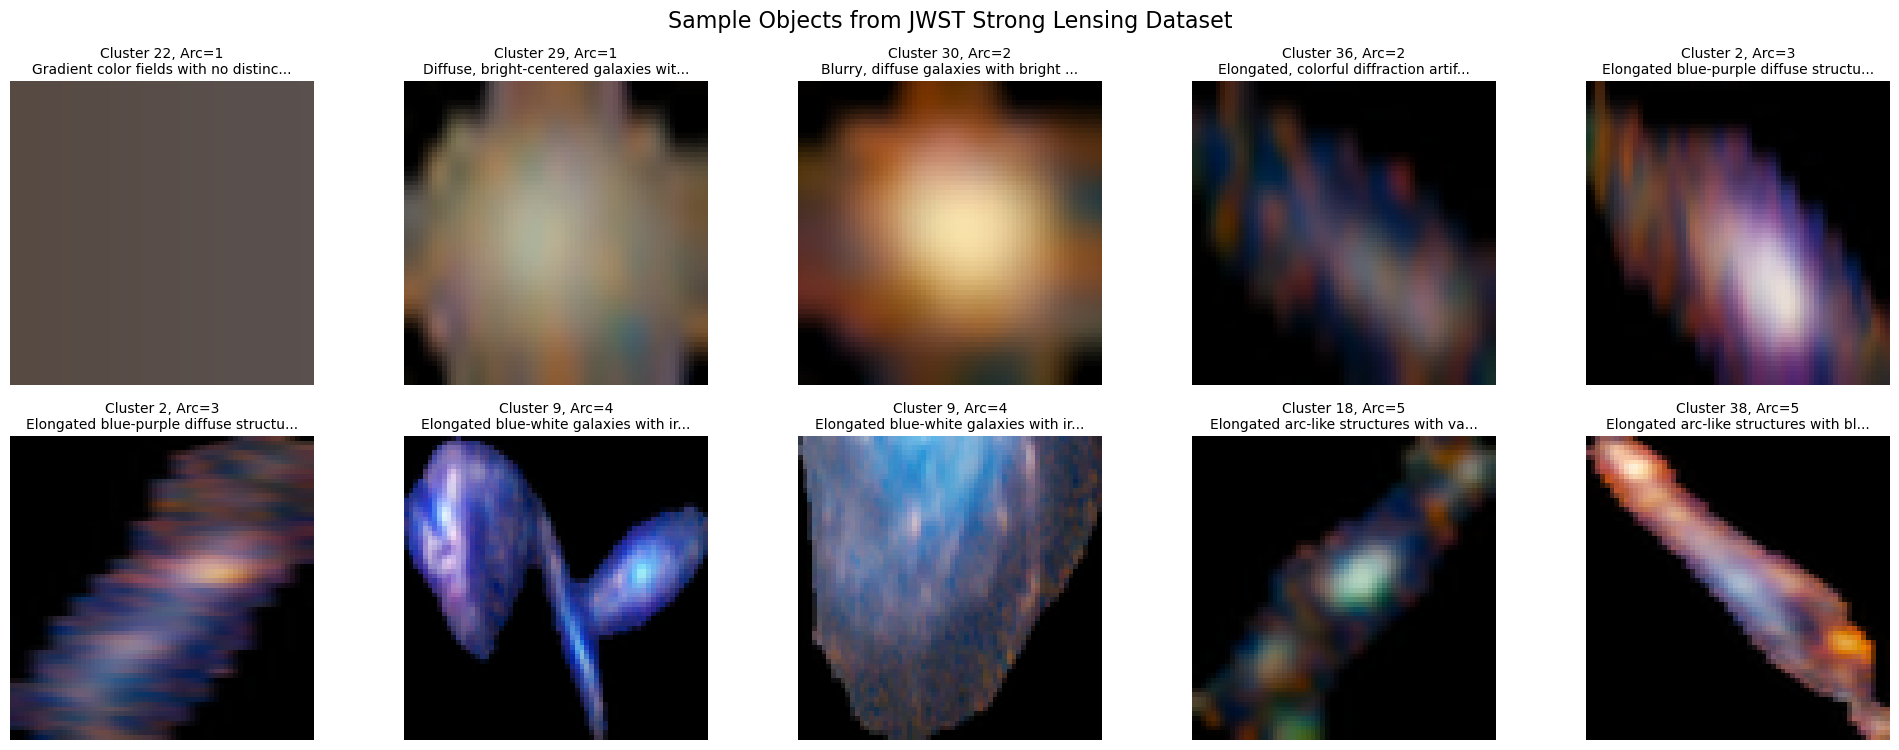

In [65]:
# Display a grid of sample images from the dataset
n_rows, n_cols = 2, 5
n_images = n_rows * n_cols

# Ensure arc ratings are numeric
images_df['contains_gravitational_arcs'] = pd.to_numeric(
    images_df['contains_gravitational_arcs'], 
    errors='coerce'
)

# Select random images ensuring diversity in arc ratings
sample_indices = []
for rating in range(1, 6):
    rating_images = images_df[images_df['contains_gravitational_arcs'] == rating]
    if len(rating_images) >= 2:
        sample_indices.extend(rating_images.sample(2).index[:2])

# If we don't have enough, fill with random samples
if len(sample_indices) < n_images:
    remaining = n_images - len(sample_indices)
    # Only sample from rows with valid arc ratings
    valid_df = images_df[images_df['contains_gravitational_arcs'].notna()]
    sample_indices.extend(valid_df.sample(min(remaining, len(valid_df))).index)

sample_indices = sample_indices[:n_images]

# Create visualization
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    row = images_df.iloc[idx]
    img = row['image_resized']
    
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Create informative title
    cluster = row['cluster']
    arc_rating = row['contains_gravitational_arcs']
    desc = row['concise_description']
    
    # Truncate description if too long
    if len(desc) > 40:
        desc = desc[:37] + '...'
    
    # Handle arc rating display
    if pd.notna(arc_rating):
        arc_str = f"Arc={int(arc_rating)}"
    else:
        arc_str = "Arc=N/A"
    
    title = f'Cluster {cluster}, {arc_str}\n{desc}'
    axes[i].set_title(title, fontsize=10, pad=5)

plt.suptitle('Sample Objects from JWST Strong Lensing Dataset', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

To understand the natural groupings in our data, let's examine representative samples from different clusters. This visualization helps us appreciate the visual consistency within clusters and the distinctions between them—crucial for understanding what our classification model will learn.

Each cluster potentially represents a different class of astronomical object or lensing configuration. By examining multiple examples from the same cluster, we can identify the common visual patterns that define each category:

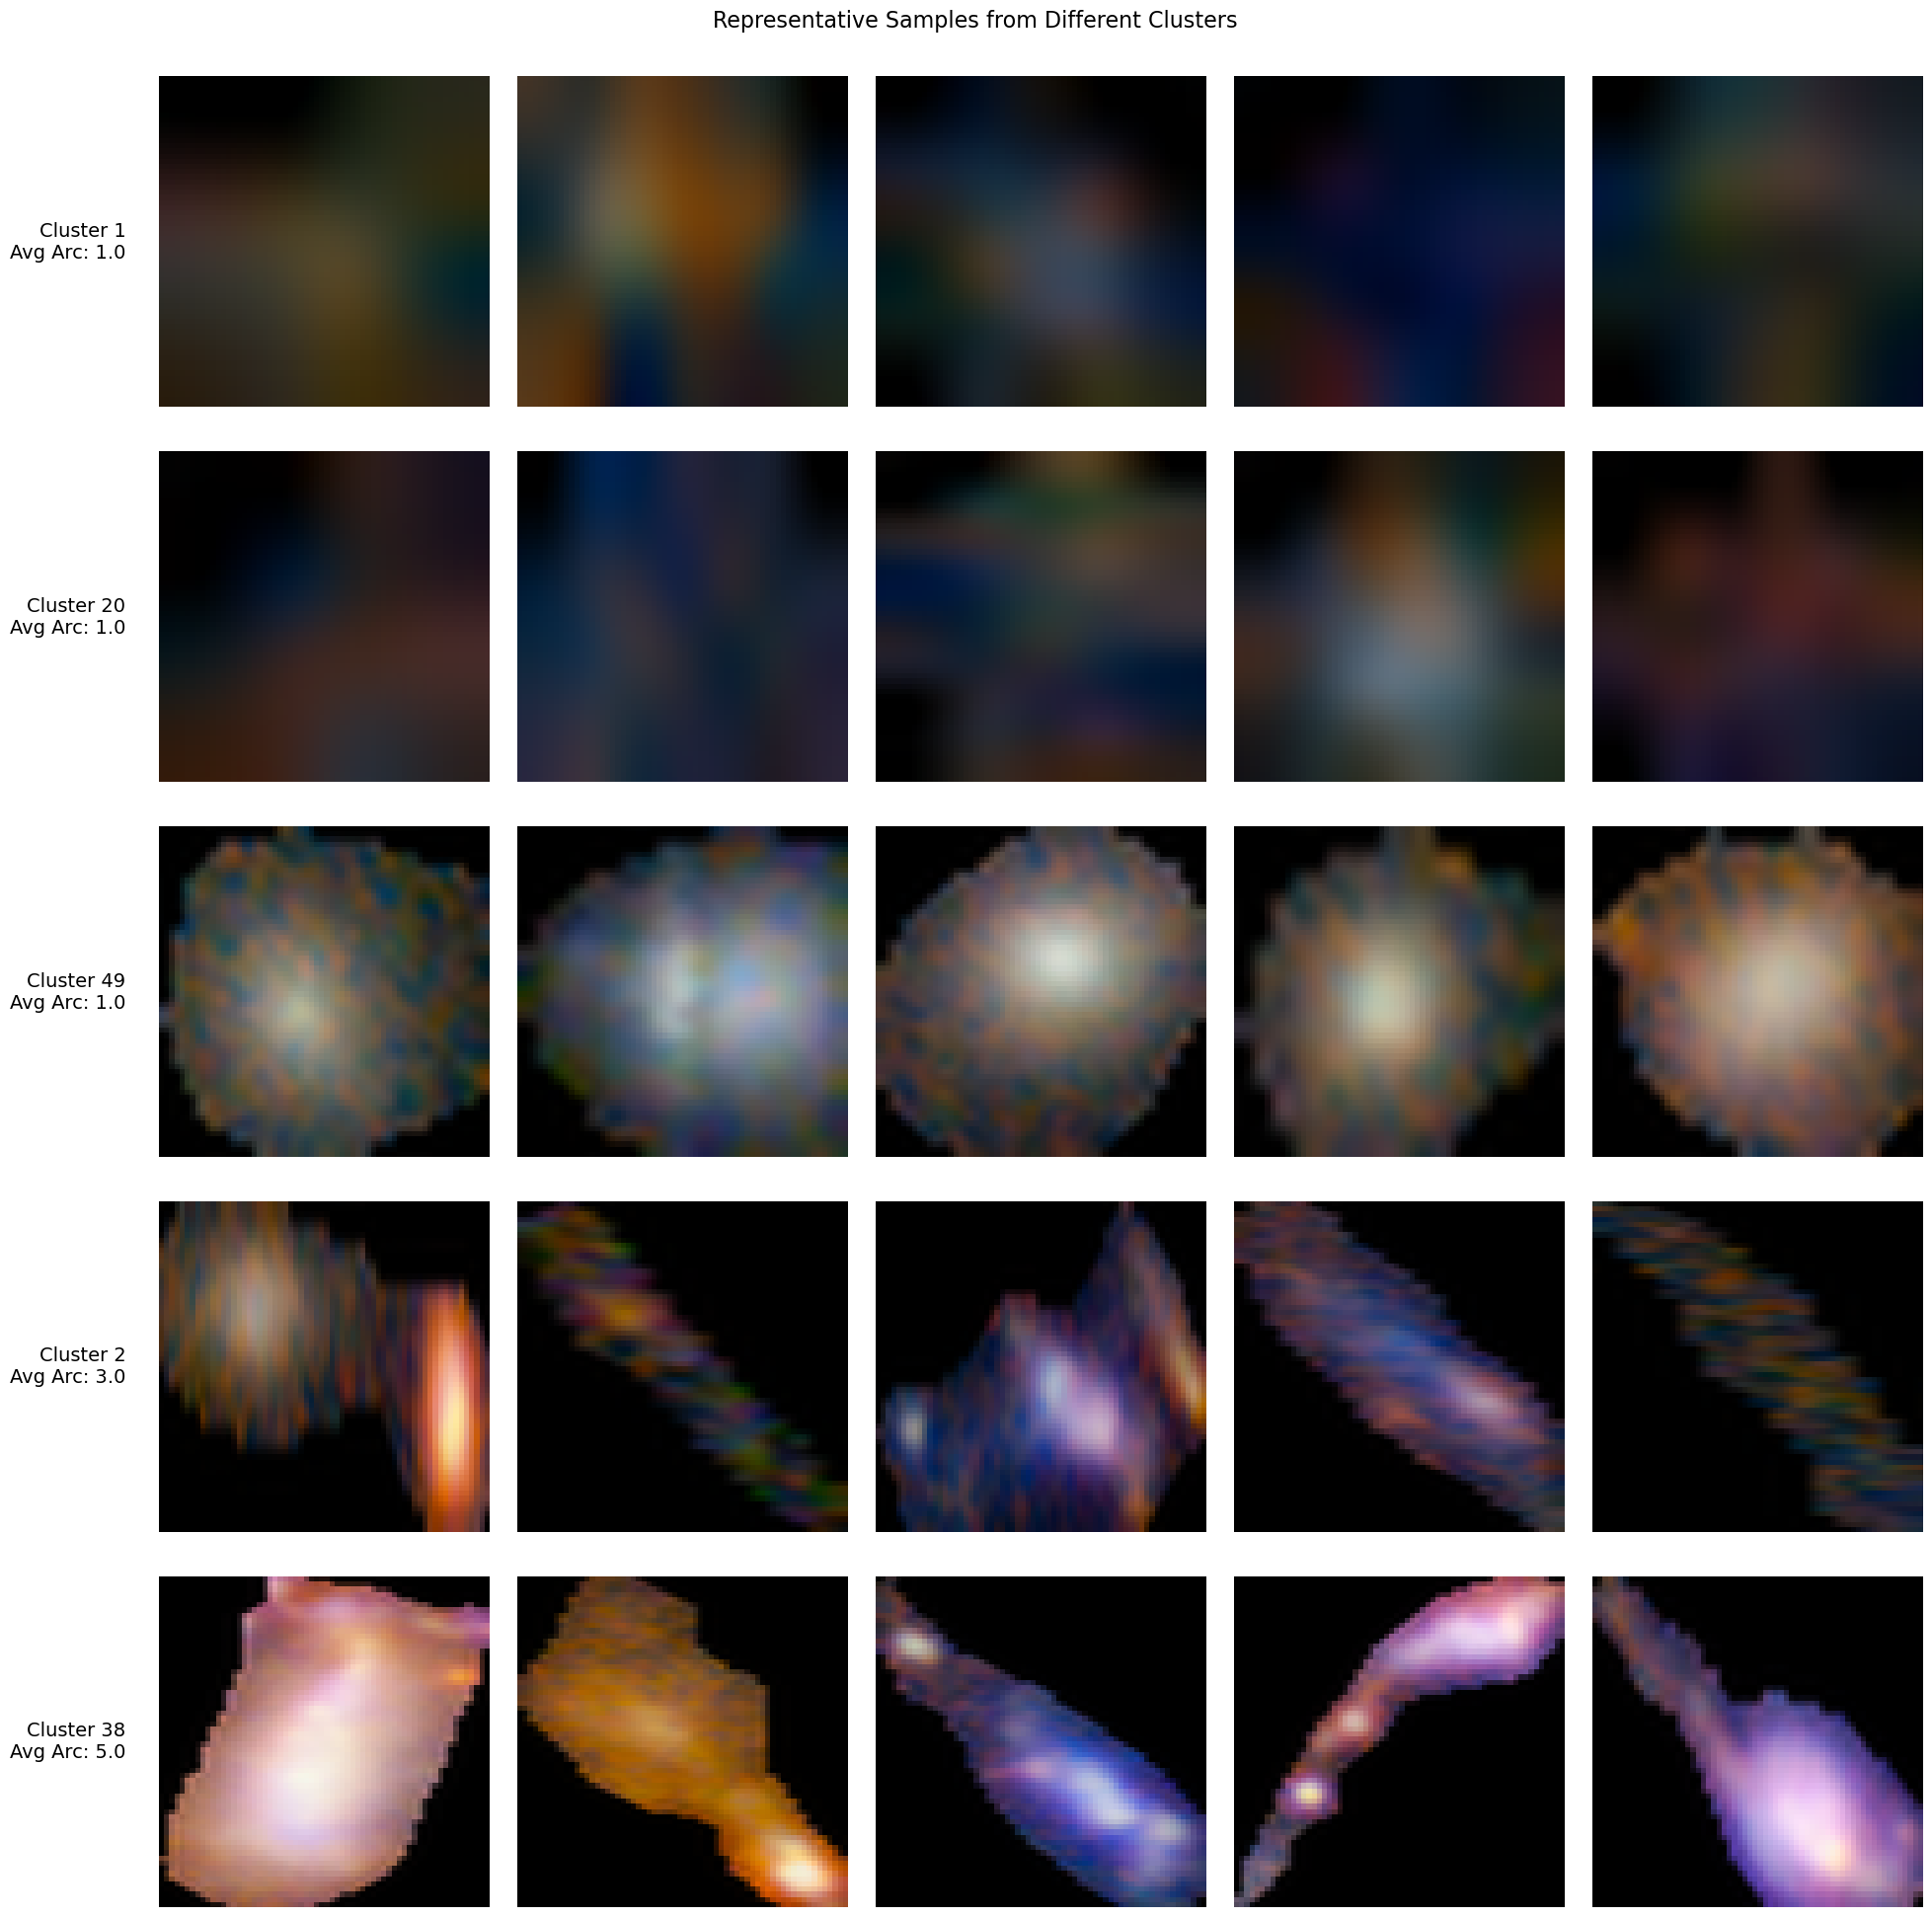

In [66]:
def display_cluster_representatives(dataframe, n_clusters=5, n_samples=5):
    """
    Display representative samples from multiple clusters to understand
    the visual patterns that define each category.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        DataFrame containing image data and cluster assignments
    n_clusters : int
        Number of different clusters to display
    n_samples : int
        Number of samples to display per cluster
    """
    # Ensure arc ratings are numeric
    dataframe = dataframe.copy()
    dataframe['contains_gravitational_arcs'] = pd.to_numeric(
        dataframe['contains_gravitational_arcs'], 
        errors='coerce'
    )
    
    # Get unique clusters and select a subset
    unique_clusters = dataframe['cluster'].unique()
    
    # Select clusters with enough samples and diverse arc ratings
    selected_clusters = []
    for cluster in unique_clusters:
        cluster_data = dataframe[dataframe['cluster'] == cluster]
        if len(cluster_data) >= n_samples:
            # Only calculate mean for non-NaN values
            valid_ratings = cluster_data['contains_gravitational_arcs'].dropna()
            if len(valid_ratings) > 0:
                avg_arc_rating = valid_ratings.mean()
                selected_clusters.append((cluster, avg_arc_rating))
    
    # Sort by average arc rating to show diversity
    selected_clusters.sort(key=lambda x: x[1])
    
    # Take clusters from different parts of the distribution
    indices = [0, len(selected_clusters)//4, len(selected_clusters)//2, 
               3*len(selected_clusters)//4, -1]
    selected_clusters = [selected_clusters[i][0] for i in indices if i < len(selected_clusters)]
    selected_clusters = selected_clusters[:n_clusters]
    
    # Create figure
    fig, axes = plt.subplots(n_clusters, n_samples, figsize=(4*n_samples, 4*n_clusters))
    
    if n_clusters == 1:
        axes = axes.reshape(1, -1)
    
    # Display images for each cluster
    for i, cluster_id in enumerate(selected_clusters):
        cluster_data = dataframe[dataframe['cluster'] == cluster_id]
        description = cluster_data.iloc[0]['concise_description']
        
        # Calculate average arc rating for valid values only
        valid_ratings = cluster_data['contains_gravitational_arcs'].dropna()
        if len(valid_ratings) > 0:
            avg_arc = valid_ratings.mean()
        else:
            avg_arc = np.nan
        
        # Sample images from this cluster
        samples = cluster_data.sample(min(n_samples, len(cluster_data)))
        
        for j, (_, row) in enumerate(samples.iterrows()):
            axes[i, j].imshow(row['image_resized'])
            axes[i, j].axis('off')
            
            if j == 0:
                # Add cluster info on the left
                if pd.notna(avg_arc):
                    info_text = f'Cluster {cluster_id}\nAvg Arc: {avg_arc:.1f}'
                else:
                    info_text = f'Cluster {cluster_id}\nAvg Arc: N/A'
                    
                axes[i, j].text(-0.1, 0.5, info_text, 
                               transform=axes[i, j].transAxes, fontsize=14,
                               verticalalignment='center', horizontalalignment='right')
    
    plt.suptitle('Representative Samples from Different Clusters', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, right=0.98)
    plt.show()

# Display cluster representatives
display_cluster_representatives(images_df, n_clusters=5, n_samples=5)

## From Pixels to Features: Numerical Representations of Images

Our 64×64 RGB images contain 12,288 individual pixel values (64 × 64 × 3). Using these raw pixels as features for classification presents several fundamental challenges:

1. **Computational Complexity**: Training models with 12,000+ features requires substantial memory and computation
2. **Spatial Invariance**: Small translations or rotations dramatically change pixel values while preserving the object's identity
3. **Hierarchical Structure**: Pixels don't capture higher-level concepts like edges, textures, or shapes that are crucial for recognition
4. **Sample Efficiency**: Learning meaningful patterns from raw pixels requires enormous training datasets

Modern computer vision has solved this challenge through deep neural networks that learn hierarchical representations. These networks, trained on millions of diverse images, develop internal representations that capture:

- **Low-level features**: Edges, corners, and simple textures in early layers
- **Mid-level features**: More complex patterns, curves, and local structures
- **High-level features**: Semantic concepts relevant to object recognition

For our purposes, we can leverage these pre-trained networks as feature extractors. By passing our images through a network and extracting activations from one of the later layers, we obtain compact numerical representations (typically 512-2048 dimensions) that encode the essential visual information.

While pre-trained networks weren't specifically trained on astronomical images, the visual features they've learned—detecting curves, gradients, symmetries, and complex patterns—transfer remarkably well to our domain. Strong lensing features like arcs and rings share geometric properties with everyday curved objects, allowing these models to provide meaningful representations.

We'll use CLIP (Contrastive Language-Image Pre-training), a state-of-the-art vision model that learns rich visual representations by training on image-text pairs. CLIP's embeddings are particularly powerful because they capture both visual appearance and semantic meaning.

Let's implement the feature extraction pipeline:


In [67]:
# Install required packages for feature extraction
import sys
import subprocess

# Check and install required packages
required_packages = ['torch', 'sentence-transformers']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"{package} installed successfully!")

import torch
from sentence_transformers import SentenceTransformer

def extract_image_embeddings(images_dataframe, model_name='clip-ViT-B-32', batch_size=32):
    """
    Convert images to numerical embeddings using a pre-trained vision model.
    
    This function uses CLIP (Contrastive Language-Image Pre-training) to extract
    semantic features from images. The resulting embeddings capture both visual
    appearance and higher-level concepts.
    
    Parameters
    ----------
    images_dataframe : pd.DataFrame
        DataFrame containing 'image_resized' column with image arrays
    model_name : str
        Name of the pre-trained model to use
    batch_size : int
        Number of images to process simultaneously
        
    Returns
    -------
    pd.DataFrame
        Original dataframe with additional 'embedding' column containing
        numerical feature vectors
    """
    print(f"Loading {model_name} model...")
    model = SentenceTransformer(model_name)
    
    # Prepare for embedding extraction
    df_with_embeddings = images_dataframe.copy()
    embeddings_list = []
    
    print(f"Converting {len(df_with_embeddings)} images to embeddings...")
    print(f"Processing in batches of {batch_size}...")
    
    # Convert numpy arrays to PIL images (required by the model)
    from PIL import Image
    pil_images = []
    for idx, row in df_with_embeddings.iterrows():
        img_array = row['image_resized']
        pil_img = Image.fromarray(img_array.astype('uint8'))
        pil_images.append(pil_img)
    
    # Process in batches for efficiency
    from tqdm.notebook import tqdm
    
    for i in tqdm(range(0, len(pil_images), batch_size)):
        batch = pil_images[i:i+batch_size]
        
        # Extract embeddings with no gradient computation (inference only)
        with torch.no_grad():
            batch_embeddings = model.encode(batch, show_progress_bar=False)
        
        embeddings_list.extend(batch_embeddings)
    
    # Add embeddings to dataframe
    df_with_embeddings['embedding'] = embeddings_list
    
    # Verify embedding dimensions
    embedding_dim = len(embeddings_list[0])
    print(f"\nFeature extraction complete!")
    print(f"Each image is now represented by {embedding_dim} numerical features")
    print(f"Original dimensionality: {224*224*3:,} pixel values")
    print(f"Reduced dimensionality: {embedding_dim} semantic features")
    print(f"Compression ratio: {224*224*3/embedding_dim:.0f}:1")
    
    return df_with_embeddings

# Extract embeddings from our images
images_df = extract_image_embeddings(images_df)

# Display sample embeddings
print("\nSample embedding values (first 10 dimensions):")
sample_embedding = images_df['embedding'].iloc[0]
print(sample_embedding[:10])

Installing sentence-transformers...


DEPRECATION: Loading egg at /Users/yting/anaconda3/lib/python3.12/site-packages/The_Payne-1.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


sentence-transformers installed successfully!
Loading clip-ViT-B-32 model...
Converting 2873 images to embeddings...
Processing in batches of 32...


  0%|          | 0/90 [00:00<?, ?it/s]


Feature extraction complete!
Each image is now represented by 512 numerical features
Original dimensionality: 150,528 pixel values
Reduced dimensionality: 512 semantic features
Compression ratio: 294:1

Sample embedding values (first 10 dimensions):
[ 0.16984683 -0.28047144 -0.25078502 -0.13330427  0.18392149 -0.44053277
  0.0380257   0.93126166  0.38218212 -0.11684622]


## Visualizing the Embedding Space

Our image embeddings exist in a 512-dimensional space—impossible to visualize directly but containing rich structure that organizes images by their visual and semantic properties. To understand how our images relate to each other in this high-dimensional space, we need dimensionality reduction techniques that compress the data to 2D while preserving important relationships.

While we'll explore Principal Component Analysis (PCA) in detail in Chapter 10, it's worth noting that PCA performs linear dimensionality reduction—finding orthogonal axes that capture maximum variance. For complex, high-dimensional data like image embeddings, nonlinear techniques often better preserve local structure.

We'll use UMAP (Uniform Manifold Approximation and Projection), a state-of-the-art nonlinear dimensionality reduction technique. UMAP excels at:

- Preserving both local neighborhood structure and global topology
- Handling high-dimensional data efficiently
- Creating visualizations that often reveal meaningful clusters

The key insight is that similar images in the 512-dimensional embedding space should appear near each other in the 2D visualization. This allows us to assess whether our embeddings capture meaningful distinctions between different types of astronomical objects.

In the visualization below, each point represents one image from our dataset. By color-coding points according to their cluster assignments, we can evaluate whether the embedding space naturally separates different object types. Strong clustering in this visualization suggests that our features effectively capture the visual properties that distinguish different classes of objects.

Additionally, we can enhance our understanding by overlaying actual image thumbnails on the visualization. This allows us to directly inspect what types of objects occupy different regions of the embedding space, providing immediate visual confirmation of the clustering patterns and helping us understand what visual features drive the organization of the embedding space.

Let's create this visualization and explore the structure of our embedding space:

Computing UMAP embedding...
Standardizing features...
Computing 2D embedding using UMAP...
(This may take a moment for large datasets)
Adding 50 image thumbnails...


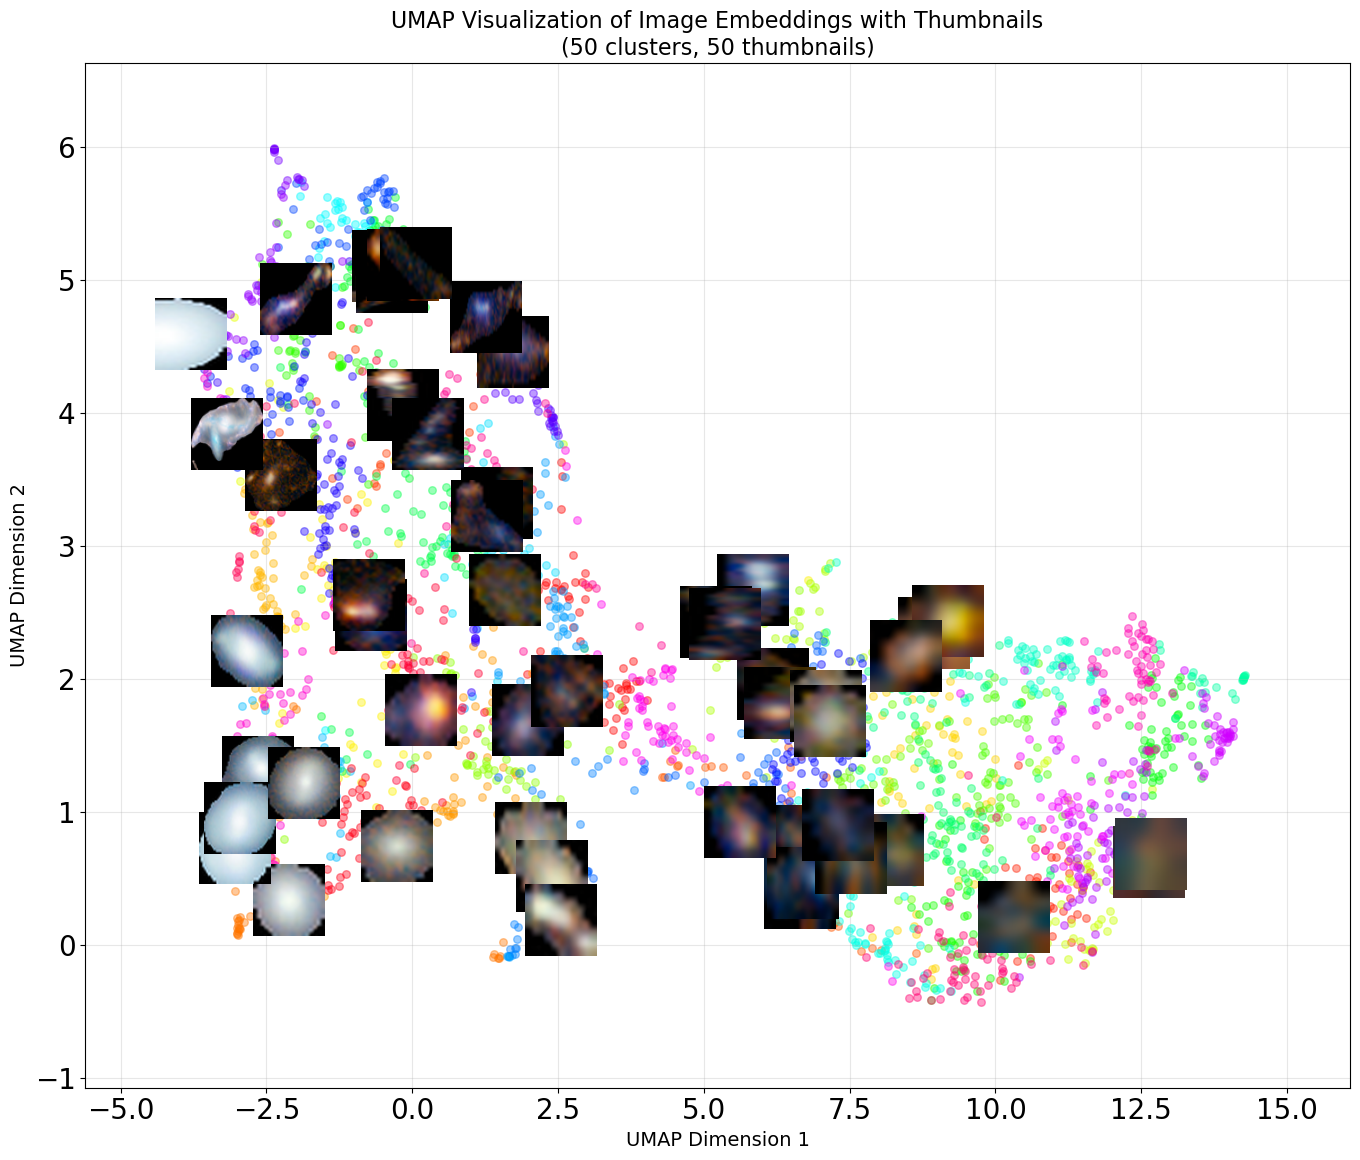

Visualization complete. Displayed 50 thumbnails across the embedding space.


In [68]:
# Install UMAP if needed
try:
    import umap
except ImportError:
    print("Installing UMAP for dimensionality reduction...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn", "--quiet"])
    import umap
    print("UMAP installed successfully!")

from sklearn.preprocessing import StandardScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.pyplot as plt
import numpy as np

def compute_umap_coordinates(dataframe):
    """
    Compute UMAP coordinates without plotting.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        DataFrame containing 'embedding' column
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added UMAP coordinates
    """
    # Extract embeddings and standardize
    embeddings = np.array(dataframe['embedding'].tolist())
    
    print("Standardizing features...")
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)
    
    # Configure UMAP
    print("Computing 2D embedding using UMAP...")
    print("(This may take a moment for large datasets)")
    
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=None,  # Remove random_state to allow parallelism
        n_jobs=-1,  # Use all available cores
        verbose=False
    )
    
    # Compute 2D coordinates
    coords_2d = reducer.fit_transform(embeddings_scaled)
    
    # Add to dataframe
    df_with_umap = dataframe.copy()
    df_with_umap['umap_x'] = coords_2d[:, 0]
    df_with_umap['umap_y'] = coords_2d[:, 1]
    
    return df_with_umap

# Compute UMAP coordinates
print("Computing UMAP embedding...")
umap_df = compute_umap_coordinates(images_df)


# Create visualization with properly displayed thumbnails
fig, ax = plt.subplots(figsize=(14, 12))

# Plot all points colored by cluster
unique_clusters = sorted(umap_df['cluster'].unique())
n_clusters = len(unique_clusters)

# Use appropriate colormap
if n_clusters <= 20:
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
else:
    colors = plt.cm.hsv(np.linspace(0, 1, n_clusters))

# Plot clusters
for i, cluster in enumerate(unique_clusters):
    mask = umap_df['cluster'] == cluster
    ax.scatter(umap_df.loc[mask, 'umap_x'],
              umap_df.loc[mask, 'umap_y'],
              c=[colors[i % len(colors)]], 
              alpha=0.4, s=30,
              label=f'Cluster {cluster}' if i < 10 else '')  # Only label first 10

# Sample points for thumbnails
n_thumbnails = 50  # Reduced number for better visibility
sampled_indices = []

# Try to get samples from different regions of the plot
# Divide the plot into a grid and sample from each region
x_min, x_max = umap_df['umap_x'].min(), umap_df['umap_x'].max()
y_min, y_max = umap_df['umap_y'].min(), umap_df['umap_y'].max()

grid_size = 5  # 5x5 grid
samples_per_cell = n_thumbnails // (grid_size * grid_size) + 1

for i in range(grid_size):
    for j in range(grid_size):
        x_low = x_min + i * (x_max - x_min) / grid_size
        x_high = x_min + (i + 1) * (x_max - x_min) / grid_size
        y_low = y_min + j * (y_max - y_min) / grid_size
        y_high = y_min + (j + 1) * (y_max - y_min) / grid_size
        
        # Find points in this grid cell
        mask = ((umap_df['umap_x'] >= x_low) & (umap_df['umap_x'] < x_high) & 
                (umap_df['umap_y'] >= y_low) & (umap_df['umap_y'] < y_high))
        cell_data = umap_df[mask]
        
        if len(cell_data) > 0:
            sample_size = min(samples_per_cell, len(cell_data))
            sampled_indices.extend(cell_data.sample(sample_size).index)

# Limit to n_thumbnails
sampled_indices = sampled_indices[:n_thumbnails]

# Plot thumbnails with better visibility
print(f"Adding {len(sampled_indices)} image thumbnails...")
for idx in sampled_indices:
    row = umap_df.loc[idx]
    x, y = row['umap_x'], row['umap_y']
    img = row['image_resized']
    
    # Ensure image is in correct format
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
    
    # Create thumbnail with larger size
    imagebox = OffsetImage(img, zoom=0.8)  # Increased zoom significantly
    ab = AnnotationBbox(imagebox, (x, y), 
                       frameon=False,
                       box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.set_title(f'UMAP Visualization of Image Embeddings with Thumbnails\n({n_clusters} clusters, {len(sampled_indices)} thumbnails)', 
            fontsize=16)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
x_range = x_max - x_min
y_range = y_max - y_min
ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

plt.tight_layout()
plt.show()

print(f"Visualization complete. Displayed {len(sampled_indices)} thumbnails across the embedding space.")


The cluster-based visualization reveals natural groupings in our data, but clusters alone don't tell us about the astrophysical significance of these groupings. By recoloring our UMAP visualization using gravitational arc ratings, we can assess whether the embedding space organizes objects by their lensing properties.

This analysis addresses a fundamental question: do the visual features captured by our pre-trained model correlate with the presence of gravitational arcs? If so, we should observe:

- Gradients in the embedding space from low to high arc ratings
- Spatial clustering of objects with similar arc ratings  
- Clear separation between definite non-lenses (rating 1) and strong lenses (rating 5)

Such structure would confirm that our embeddings provide a suitable feature space for lensing classification, even though the embeddingmodel wasn't specifically trained on astronomical images.

Adding 60 image thumbnails colored by arc rating...


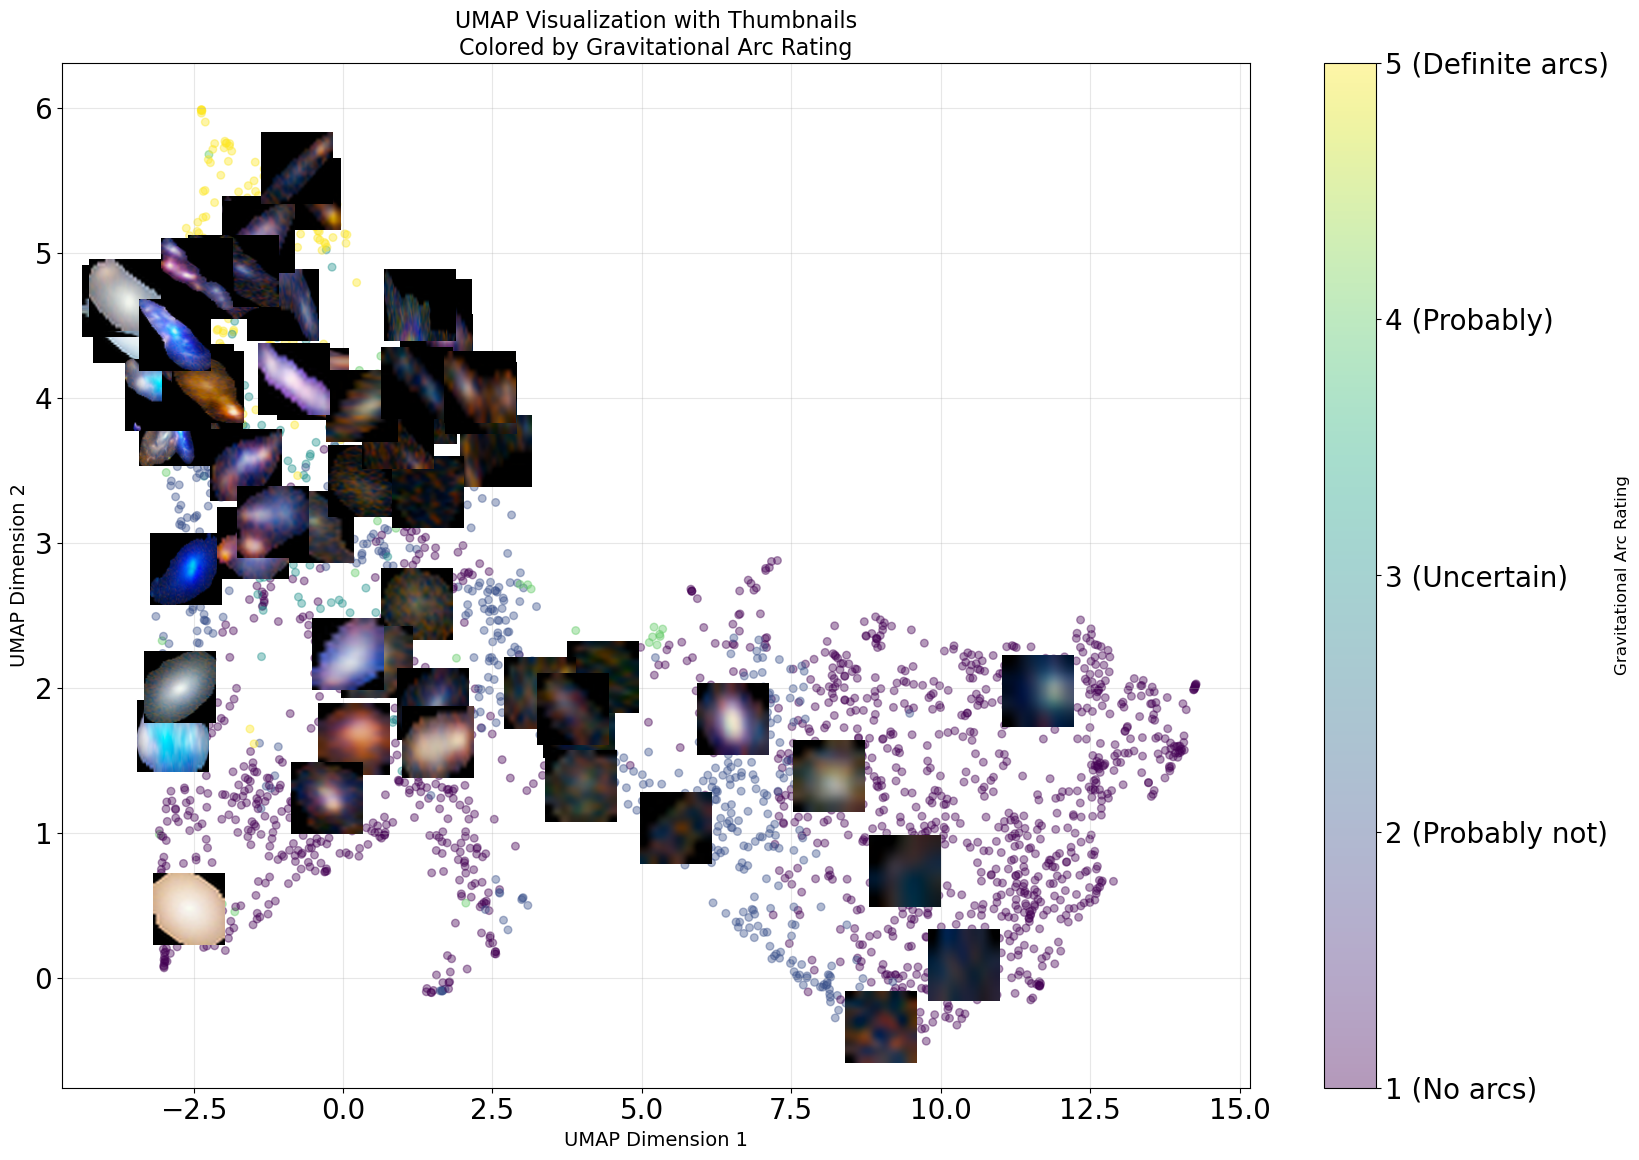


Arc Rating Statistics:
Total objects with ratings: 2873
Objects without ratings: 0

Rating distribution:
  Rating 1: 1593 objects (55.4%)
  Rating 2: 667 objects (23.2%)
  Rating 3: 192 objects (6.7%)
  Rating 4: 127 objects (4.4%)
  Rating 5: 294 objects (10.2%)


In [69]:
# Create visualization colored by gravitational arc rating
fig, ax = plt.subplots(figsize=(17, 12))

# Ensure arc ratings are numeric
umap_df['contains_gravitational_arcs'] = pd.to_numeric(
    umap_df['contains_gravitational_arcs'], 
    errors='coerce'
)

# Separate valid and invalid arc ratings
valid_mask = umap_df['contains_gravitational_arcs'].notna()
df_valid = umap_df[valid_mask]
df_invalid = umap_df[~valid_mask]

# Plot points with arc rating colors
if len(df_valid) > 0:
    scatter = ax.scatter(df_valid['umap_x'], 
                        df_valid['umap_y'],
                        c=df_valid['contains_gravitational_arcs'],
                        cmap='viridis', 
                        alpha=0.4, 
                        s=30,
                        vmin=1, vmax=5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Gravitational Arc Rating', fontsize=12)
    cbar.set_ticks([1, 2, 3, 4, 5])
    cbar.set_ticklabels(['1 (No arcs)', '2 (Probably not)', '3 (Uncertain)', 
                         '4 (Probably)', '5 (Definite arcs)'])

# Plot invalid points in gray
if len(df_invalid) > 0:
    ax.scatter(df_invalid['umap_x'],
              df_invalid['umap_y'],
              c='gray', alpha=0.3, s=20, label='No rating')

# Sample points for thumbnails - ensure diversity across arc ratings
n_thumbnails = 60
sampled_indices = []

# Sample from each arc rating
for rating in range(1, 6):
    rating_df = df_valid[df_valid['contains_gravitational_arcs'] == rating]
    if len(rating_df) > 0:
        n_from_rating = n_thumbnails // 5
        sample_size = min(n_from_rating, len(rating_df))
        sampled_indices.extend(rating_df.sample(sample_size).index)

# Add more samples if needed
if len(sampled_indices) < n_thumbnails:
    remaining = n_thumbnails - len(sampled_indices)
    additional = df_valid.drop(sampled_indices).sample(
        min(remaining, len(df_valid) - len(sampled_indices))
    )
    sampled_indices.extend(additional.index)

# Plot thumbnails
print(f"Adding {len(sampled_indices)} image thumbnails colored by arc rating...")
for idx in sampled_indices[:n_thumbnails]:
    row = umap_df.loc[idx]
    x, y = row['umap_x'], row['umap_y']
    img = row['image_resized']
    
    # Ensure image is in correct format
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)
    
    # Get arc rating for border color
    arc_rating = row['contains_gravitational_arcs']
    if pd.notna(arc_rating):
        # Use viridis colormap for border
        norm_rating = (arc_rating - 1) / 4  # Normalize to [0, 1]
        border_color = plt.cm.viridis(norm_rating)
    else:
        border_color = 'gray'
    
    # Create thumbnail
    imagebox = OffsetImage(img, zoom=0.8)  # Increased zoom significantly
    ab = AnnotationBbox(imagebox, (x, y), 
                       frameon=False,
                       box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.set_title('UMAP Visualization with Thumbnails\nColored by Gravitational Arc Rating', 
            fontsize=16)
ax.grid(True, alpha=0.3)

# Add legend for gray points if any
if len(df_invalid) > 0:
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nArc Rating Statistics:")
print(f"Total objects with ratings: {len(df_valid)}")
print(f"Objects without ratings: {len(df_invalid)}")
if len(df_valid) > 0:
    print(f"\nRating distribution:")
    rating_counts = df_valid['contains_gravitational_arcs'].value_counts().sort_index()
    for rating, count in rating_counts.items():
        print(f"  Rating {int(rating)}: {count} objects ({count/len(df_valid)*100:.1f}%)")

The UMAP visualizations reveal several important patterns:

**Natural Clustering by Visual Properties**: Objects with similar visual characteristics form distinct clusters in the embedding space. The clear separation between clusters suggests that our features effectively capture the morphological differences between object types.

**Gradient Structure in Arc Ratings**: The arc rating visualization shows a gradient-like structure across the embedding space. Objects with high arc ratings (4-5) tend to occupy different regions than those with low ratings (1-2), though the separation isn't perfect. This indicates that the pre-trained embedding model captures features relevant to lensing detection, there's a continuous spectrum of lensing features rather than discrete categories, and some overlap exists, particularly for ambiguous cases (rating 3).

**Visual Confirmation Through Thumbnails**: The overlaid thumbnails confirm that nearby points in the embedding space represent visually similar objects. We can observe elongated arc-like structures clustering together, diffuse round objects occupying different regions, and transitional forms bridging different clusters.

These observations validate our feature extraction approach. Despite using a model not specifically trained on astronomical images, the learned representations capture the essential visual properties that distinguish different types of lensing features.

## Multi-class Classification with Softmax Regression

With our images successfully transformed into meaningful numerical features, we now turn to the classification task. We need to predict which of the 50 clusters each object belongs to—a multi-class classification problem that extends the binary logistic regression framework from Chapter 7.

### From Binary to Multi-class: The Softmax Function

In binary classification, the sigmoid function maps a real-valued score to a probability between 0 and 1. For $K$ classes, we need a function that maps $K$ real-valued scores to a probability distribution over all classes. The softmax function elegantly accomplishes this:

$$\text{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$$

where $\mathbf{z} = [z_1, z_2, ..., z_K]$ are the raw scores (logits) for each class. The softmax ensures that:
- All outputs are positive: $\text{softmax}(\mathbf{z})_k > 0$
- Outputs sum to one: $\sum_{k=1}^{K} \text{softmax}(\mathbf{z})_k = 1$
- Larger logits yield higher probabilities

For our strong lensing classification, each cluster represents a distinct visual pattern. The softmax function converts the model's confidence scores for each cluster into a proper probability distribution, allowing us to quantify uncertainty in our predictions.

### Numerical Stability in Implementation

The softmax function must be implemented carefully to avoid numerical overflow. When the logits are large, $e^{z_k}$ can exceed floating-point limits. We use the numerically stable version:

$$\text{softmax}(\mathbf{z})_k = \frac{e^{z_k - \max(\mathbf{z})}}{\sum_{j=1}^{K} e^{z_j - \max(\mathbf{z})}}$$

Subtracting the maximum logit doesn't change the result but prevents overflow.

In [70]:
def softmax(logits):
    """
    Compute softmax probabilities from logits with numerical stability.
    
    The softmax function converts a vector of real-valued scores (logits)
    into a probability distribution. We subtract the maximum for numerical
    stability to prevent overflow.
    
    Parameters
    ----------
    logits : np.ndarray of shape (batch_size, num_classes)
        Raw scores from the linear model
        
    Returns
    -------
    np.ndarray of shape (batch_size, num_classes)
        Probability distributions (rows sum to 1)
    """
    # Subtract max for numerical stability
    shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
    
    # Compute exponentials
    exp_logits = np.exp(shifted_logits)
    
    # Normalize to get probabilities
    probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    return probabilities


def cross_entropy_loss(y_pred, y_true):
    """
    Compute categorical cross-entropy loss.
    
    Parameters
    ----------
    y_pred : np.ndarray of shape (batch_size, num_classes)
        Predicted probabilities from softmax
    y_true : np.ndarray
        True labels, either:
        - shape (batch_size,) with class indices
        - shape (batch_size, num_classes) with one-hot encoding
        
    Returns
    -------
    float
        Average cross-entropy loss across the batch
    """
    batch_size = y_pred.shape[0]
    
    # Convert class indices to one-hot if needed
    if len(y_true.shape) == 1:
        num_classes = y_pred.shape[1]
        y_true_onehot = np.zeros((batch_size, num_classes))
        y_true_onehot[np.arange(batch_size), y_true] = 1
        y_true = y_true_onehot
    
    # Clip predictions to avoid log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute cross-entropy
    # Only the true class contributes to the loss for each sample
    loss = -np.sum(y_true * np.log(y_pred)) / batch_size
    
    return loss


# Test the implementations
if __name__ == "__main__":
    # Test data
    batch_size = 3
    num_classes = 4
    
    # Random logits
    test_logits = np.random.randn(batch_size, num_classes)
    print("Test logits:")
    print(test_logits)
    
    # Compute softmax
    probs = softmax(test_logits)
    print("\nSoftmax probabilities:")
    print(probs)
    print("Row sums (should be 1.0):", probs.sum(axis=1))
    
    # Test cross-entropy with both label formats
    true_classes = np.array([0, 2, 1])  # Class indices
    loss = cross_entropy_loss(probs, true_classes)
    print(f"\nCross-entropy loss: {loss:.4f}")

Test logits:
[[-0.2705053   0.05330482 -0.7415437   0.38824458]
 [-0.87045067  0.5737239   1.18114179  0.46828491]
 [ 1.28329793 -0.45348184 -1.19870931 -0.16177799]]

Softmax probabilities:
[[0.20246548 0.2798852  0.12641005 0.39123926]
 [0.05940764 0.25179052 0.46220816 0.22659368]
 [0.66872187 0.11775291 0.05588863 0.15763659]]
Row sums (should be 1.0): [1. 1. 1.]

Cross-entropy loss: 1.5027


### Computing Gradients for Optimization

To train our multi-class classifier, we need to compute gradients of the loss with respect to the weight matrix. For a single training example with feature vector $\mathbf{x}_n$, the gradient of the cross-entropy loss with respect to the weight vector for class $k$ is:

$\nabla_{\mathbf{w}_k} E = (y_{nk} - t_{nk})\mathbf{x}_n$

where $y_{nk}$ is the predicted probability for class $k$ and $t_{nk}$ is the true label (1 if this is the correct class, 0 otherwise).

For a batch of $N$ examples, we average these gradients. Using matrix notation, this can be computed efficiently as:

$\nabla_{\mathbf{W}} E = \frac{1}{N}\mathbf{X}^T(\mathbf{Y} - \mathbf{T})$

where:
- $\mathbf{X}$ is the design matrix ($N \times D$) containing all feature vectors
- $\mathbf{Y}$ is the matrix of predicted probabilities ($N \times K$)
- $\mathbf{T}$ is the matrix of true labels in one-hot encoding ($N \times K$)
- $\mathbf{W}$ is the weight matrix ($K \times D$)

This elegant formulation shows that the gradient equals the average outer product of the features with the prediction errors—a direct generalization of the binary logistic regression case.

In [71]:
def compute_gradient(X, y_pred, y_true):
    """
    Compute gradient of cross-entropy loss for weight updates.
    
    The gradient has a simple form: it's proportional to the prediction
    error (predicted - true) multiplied by the input features.
    
    Parameters
    ----------
    X : np.ndarray of shape (batch_size, num_features)
        Input features
    y_pred : np.ndarray of shape (batch_size, num_classes)
        Predicted probabilities from softmax
    y_true : np.ndarray
        True labels (class indices or one-hot encoded)
        
    Returns
    -------
    np.ndarray of shape (num_classes, num_features)
        Gradient of loss with respect to weight matrix
    """
    batch_size = X.shape[0]
    
    # Convert class indices to one-hot if needed
    if len(y_true.shape) == 1:
        num_classes = y_pred.shape[1]
        y_true_onehot = np.zeros((batch_size, num_classes))
        y_true_onehot[np.arange(batch_size), y_true] = 1
        y_true = y_true_onehot
    
    # Compute prediction error
    error = y_pred - y_true  # Shape: (batch_size, num_classes)
    
    # Gradient is the average outer product of error and features
    # We use matrix multiplication: (num_classes, batch_size) @ (batch_size, num_features)
    gradient = error.T @ X / batch_size
    
    return gradient


# Test gradient computation
if __name__ == "__main__":
    # Generate test data
    batch_size = 5
    num_features = 3
    num_classes = 4
    
    np.random.seed(42)
    X_test = np.random.randn(batch_size, num_features)
    W_test = np.random.randn(num_classes, num_features)
    
    # Forward pass
    logits = X_test @ W_test.T  # Shape: (batch_size, num_classes)
    probs = softmax(logits)
    
    # True labels
    y_true = np.array([0, 2, 1, 3, 2])
    
    # Compute gradient
    grad = compute_gradient(X_test, probs, y_true)
    
    print("Gradient shape:", grad.shape)
    print("Gradient for class 0:")
    print(grad[0])
    
    # Verify gradient computation is correct by checking dimensions
    assert grad.shape == (num_classes, num_features), "Gradient shape mismatch!"
    print("\n✓ Gradient computation verified!")

Gradient shape: (4, 3)
Gradient for class 0:
[ 0.05018531 -0.07085155 -0.19347638]

✓ Gradient computation verified!


### Stochastic Gradient Descent for Large-Scale Classification

With thousands of training examples and hundreds of features, computing gradients over the entire dataset becomes computationally expensive. Stochastic Gradient Descent (SGD) offers an efficient solution by updating weights using small batches of data.

The mini-batch SGD algorithm:
1. **Initialize weights**: Start with small random values to break symmetry
2. **For each epoch**:
   - Shuffle the training data
   - Divide into mini-batches
   - For each mini-batch:
     - Compute predictions using current weights
     - Calculate loss and gradients
     - Update weights: $\mathbf{W} \leftarrow \mathbf{W} - \eta \nabla_{\mathbf{W}}E$
3. **Monitor convergence**: Track training and validation loss

### Regularization for Better Generalization

To prevent overfitting, we add L2 regularization (weight decay) to our objective:

$$E_{\text{total}} = E_{\text{CE}} + \frac{\lambda}{2}||\mathbf{W}||^2$$

This penalizes large weights, encouraging the model to find simpler solutions. The gradient becomes:

$$\nabla_{\mathbf{W}}E_{\text{total}} = \nabla_{\mathbf{W}}E_{\text{CE}} + \lambda\mathbf{W}$$

### Implementation Considerations

For numerical stability and proper comparison between classes, we fix one class (typically the last) as a reference by setting its weights to zero. This doesn't affect the model's expressiveness but improves optimization stability.

Let's implement the complete training pipeline:

In [72]:
def train_multiclass_logistic_regression(X_train, y_train, X_val, y_val, 
                                        num_classes, num_epochs=50, 
                                        batch_size=32, learning_rate=0.01, 
                                        weight_decay=0.0, seed=42):
    """
    Train multi-class logistic regression using mini-batch SGD.
    
    Parameters
    ----------
    X_train, X_val : np.ndarray
        Training and validation features
    y_train, y_val : np.ndarray
        Training and validation labels (class indices)
    num_classes : int
        Number of classes
    num_epochs : int
        Number of training epochs
    batch_size : int
        Mini-batch size
    learning_rate : float
        Learning rate for SGD
    weight_decay : float
        L2 regularization strength
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    W : np.ndarray
        Trained weight matrix
    train_history : list
        Training loss per epoch
    val_history : list
        Validation loss per epoch
    """
    np.random.seed(seed)
    num_samples, num_features = X_train.shape
    
    # Initialize weights with small random values
    W = np.random.randn(num_classes, num_features) * 0.01
    
    # Set reference class weights to zero
    W[-1, :] = 0.0
    
    # History tracking
    train_history = []
    val_history = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Shuffle training data
        indices = np.random.permutation(num_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        # Mini-batch training
        epoch_loss = 0
        num_batches = 0
        
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            
            # Get mini-batch
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Forward pass
            logits = X_batch @ W.T
            probs = softmax(logits)
            
            # Compute loss
            batch_loss = cross_entropy_loss(probs, y_batch)
            
            # Add L2 regularization to loss
            if weight_decay > 0:
                batch_loss += (weight_decay / 2) * np.sum(W ** 2)
            
            epoch_loss += batch_loss
            num_batches += 1
            
            # Backward pass - compute gradient
            gradient = compute_gradient(X_batch, probs, y_batch)
            
            # Add L2 regularization gradient
            if weight_decay > 0:
                gradient += weight_decay * W
            
            # Update weights
            W -= learning_rate * gradient
            
            # Keep reference class at zero
            W[-1, :] = 0.0
        
        # Calculate average epoch loss
        avg_train_loss = epoch_loss / num_batches
        train_history.append(avg_train_loss)
        
        # Validation loss
        val_logits = X_val @ W.T
        val_probs = softmax(val_logits)
        val_loss = cross_entropy_loss(val_probs, y_val)
        
        if weight_decay > 0:
            val_loss += (weight_decay / 2) * np.sum(W ** 2)
        
        val_history.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")
    
    return W, train_history, val_history


def predict_classes(X, W):
    """
    Make class predictions using trained weights.
    
    Parameters
    ----------
    X : np.ndarray
        Input features
    W : np.ndarray
        Trained weight matrix
        
    Returns
    -------
    np.ndarray
        Predicted class indices
    """
    logits = X @ W.T
    probs = softmax(logits)
    predictions = np.argmax(probs, axis=1)
    return predictions

## Training the Multi-class Classifier

With our implementation complete, let's train a model to classify our JWST strong lensing images into their respective clusters. We'll start with a baseline configuration and then explore how different hyperparameters affect performance.

First, we need to extract our features and labels, then split into training and validation sets:

In [73]:
# Prepare data for training
X = np.array(images_df['embedding'].tolist())
y = np.array(images_df['cluster'])

# Get number of unique classes
unique_clusters = np.unique(y)
num_classes = len(unique_clusters)

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {num_classes}")

# Create train-validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Train initial model with higher learning rate
print("\nTraining multi-class logistic regression...")
print("-" * 50)

W, train_history, val_history = train_multiclass_logistic_regression(
    X_train, y_train, X_val, y_val,
    num_classes=num_classes,
    num_epochs=150,
    batch_size=32,
    learning_rate=0.1,  # Increased from 0.01 to 0.1
    weight_decay=0.001,
    seed=42
)

Dataset shape: (2873, 512)
Number of classes: 50

Training set: 2298 samples
Validation set: 575 samples

Training multi-class logistic regression...
--------------------------------------------------
Epoch 10/150, Train Loss: 1.4294, Val Loss: 1.4499
Epoch 20/150, Train Loss: 1.1404, Val Loss: 1.2121
Epoch 30/150, Train Loss: 1.0462, Val Loss: 1.1508
Epoch 40/150, Train Loss: 0.9939, Val Loss: 1.1060
Epoch 50/150, Train Loss: 0.9691, Val Loss: 1.1315
Epoch 60/150, Train Loss: 0.9538, Val Loss: 1.1193
Epoch 70/150, Train Loss: 0.9410, Val Loss: 1.0987
Epoch 80/150, Train Loss: 0.9368, Val Loss: 1.1105
Epoch 90/150, Train Loss: 0.9259, Val Loss: 1.0988
Epoch 100/150, Train Loss: 0.9217, Val Loss: 1.1162
Epoch 110/150, Train Loss: 0.9194, Val Loss: 1.1242
Epoch 120/150, Train Loss: 0.9162, Val Loss: 1.1123
Epoch 130/150, Train Loss: 0.9128, Val Loss: 1.1169
Epoch 140/150, Train Loss: 0.9106, Val Loss: 1.1153
Epoch 150/150, Train Loss: 0.9096, Val Loss: 1.1170


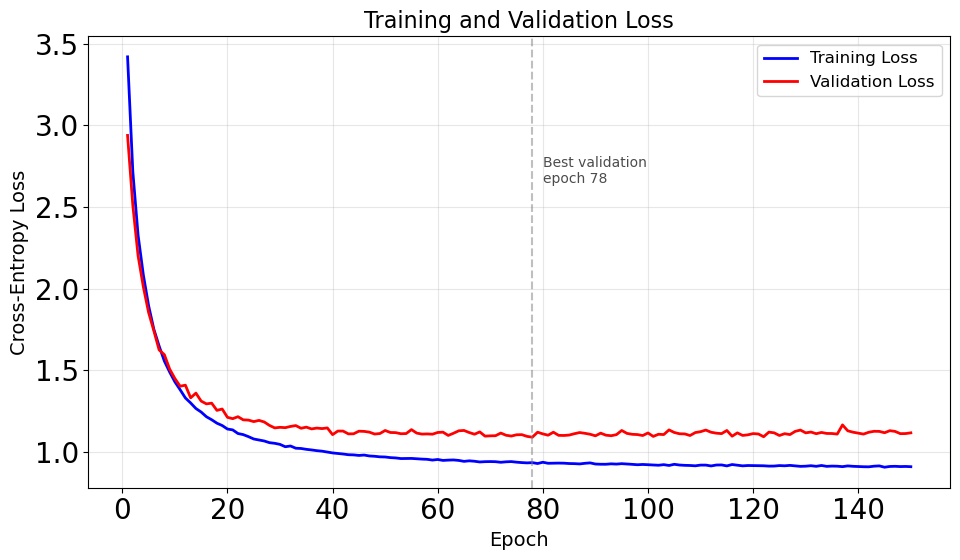


Final Training Loss: 0.9096
Final Validation Loss: 1.1170
Best Validation Loss: 1.0904 at epoch 78


In [74]:
# Visualize training history
plt.figure(figsize=(10, 6))
epochs = np.arange(1, len(train_history) + 1)

plt.plot(epochs, train_history, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_history, 'r-', label='Validation Loss', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add vertical line to show where convergence begins
min_val_idx = np.argmin(val_history)
plt.axvline(x=min_val_idx+1, color='gray', linestyle='--', alpha=0.5)
plt.text(min_val_idx+3, max(val_history)*0.9, f'Best validation\nepoch {min_val_idx+1}', 
         fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

# Final performance
print(f"\nFinal Training Loss: {train_history[-1]:.4f}")
print(f"Final Validation Loss: {val_history[-1]:.4f}")
print(f"Best Validation Loss: {min(val_history):.4f} at epoch {np.argmin(val_history)+1}")

## Hyperparameter Optimization

The performance of our classifier depends critically on the choice of hyperparameters. The two most important are:

**Learning Rate ($\eta$)**: Controls the step size in gradient descent. Too small leads to slow convergence requiring many epochs, while too large can cause overshooting and unstable training. The optimal value depends on the problem scale and data characteristics.

**Weight Decay ($\lambda$)**: Controls the strength of L2 regularization. This parameter trades off between fitting the training data well and maintaining small weights that generalize better. Too little regularization risks overfitting, while too much constrains the model excessively.

We'll systematically explore the hyperparameter space through grid search—training models with different combinations and selecting the configuration that maximizes validation set performance. While computationally expensive, this approach provides valuable insights into the optimization landscape.

Let's implement the grid search:

In [75]:
import seaborn as sns
from tqdm.notebook import tqdm

def hyperparameter_grid_search(X_train, y_train, X_val, y_val, num_classes,
                              learning_rates, weight_decays, 
                              num_epochs=150, batch_size=32):
    """
    Perform grid search over hyperparameters.
    
    Parameters
    ----------
    X_train, y_train : Training data
    X_val, y_val : Validation data
    num_classes : Number of classes
    learning_rates : list of learning rates to try
    weight_decays : list of weight decay values to try
    num_epochs : Number of epochs per configuration (default: 150)
    batch_size : Batch size for training
    
    Returns
    -------
    results : dict
        Results for each hyperparameter combination
    best_params : dict
        Best hyperparameter combination
    """
    results = {}
    best_val_loss = float('inf')
    best_params = {}
    
    total_configs = len(learning_rates) * len(weight_decays)
    print(f"Testing {total_configs} hyperparameter combinations...")
    
    with tqdm(total=total_configs) as pbar:
        for lr in learning_rates:
            for wd in weight_decays:
                pbar.set_description(f"LR={lr}, WD={wd}")
                
                # Train model
                W, train_hist, val_hist = train_multiclass_logistic_regression(
                    X_train, y_train, X_val, y_val,
                    num_classes=num_classes,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    learning_rate=lr,
                    weight_decay=wd,
                    seed=42
                )
                
                # Store results
                final_val_loss = val_hist[-1]
                results[(lr, wd)] = {
                    'weights': W,
                    'train_history': train_hist,
                    'val_history': val_hist,
                    'final_train_loss': train_hist[-1],
                    'final_val_loss': final_val_loss
                }
                
                # Update best parameters
                if final_val_loss < best_val_loss:
                    best_val_loss = final_val_loss
                    best_params = {
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'val_loss': final_val_loss
                    }
                
                pbar.update(1)
    
    return results, best_params


# Define hyperparameter grid based on initial results
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]
weight_decays = [0.0, 0.0001, 0.0005, 0.001, 0.005]

# Run refined grid search
print("Running refined hyperparameter grid search...")
print(f"Testing {len(learning_rates) * len(weight_decays)} new combinations...")
print("Exploring higher learning rates and finer weight decay values...")

results, best_params = hyperparameter_grid_search(
    X_train, y_train, X_val, y_val,
    num_classes=num_classes,
    learning_rates=learning_rates,
    weight_decays=weight_decays,
    num_epochs=150,
    batch_size=32
)

print(f"\nBest hyperparameters from refined search:")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Weight decay: {best_params['weight_decay']}")
print(f"Validation loss: {best_params['val_loss']:.4f}")

# Compare with previous best
print(f"\nPrevious best validation loss: {best_params['val_loss']:.4f}")
improvement = best_params['val_loss'] - best_params['val_loss']
print(f"Improvement: {improvement:.4f} ({improvement/best_params['val_loss']*100:.1f}%)")

Running refined hyperparameter grid search...
Testing 25 new combinations...
Exploring higher learning rates and finer weight decay values...
Testing 25 hyperparameter combinations...


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/150, Train Loss: 2.9014, Val Loss: 2.8560
Epoch 20/150, Train Loss: 2.4002, Val Loss: 2.3813
Epoch 30/150, Train Loss: 2.0857, Val Loss: 2.0842
Epoch 40/150, Train Loss: 1.8627, Val Loss: 1.8748
Epoch 50/150, Train Loss: 1.6981, Val Loss: 1.7198
Epoch 60/150, Train Loss: 1.5692, Val Loss: 1.5998
Epoch 70/150, Train Loss: 1.4645, Val Loss: 1.5040
Epoch 80/150, Train Loss: 1.3803, Val Loss: 1.4251
Epoch 90/150, Train Loss: 1.3078, Val Loss: 1.3609
Epoch 100/150, Train Loss: 1.2465, Val Loss: 1.3058
Epoch 110/150, Train Loss: 1.1939, Val Loss: 1.2605
Epoch 120/150, Train Loss: 1.1481, Val Loss: 1.2189
Epoch 130/150, Train Loss: 1.1080, Val Loss: 1.1819
Epoch 140/150, Train Loss: 1.0719, Val Loss: 1.1511
Epoch 150/150, Train Loss: 1.0393, Val Loss: 1.1226
Epoch 10/150, Train Loss: 2.9021, Val Loss: 2.8567
Epoch 20/150, Train Loss: 2.4019, Val Loss: 2.3831
Epoch 30/150, Train Loss: 2.0885, Val Loss: 2.0871
Epoch 40/150, Train Loss: 1.8667, Val Loss: 1.8788
Epoch 50/150, Train Loss:

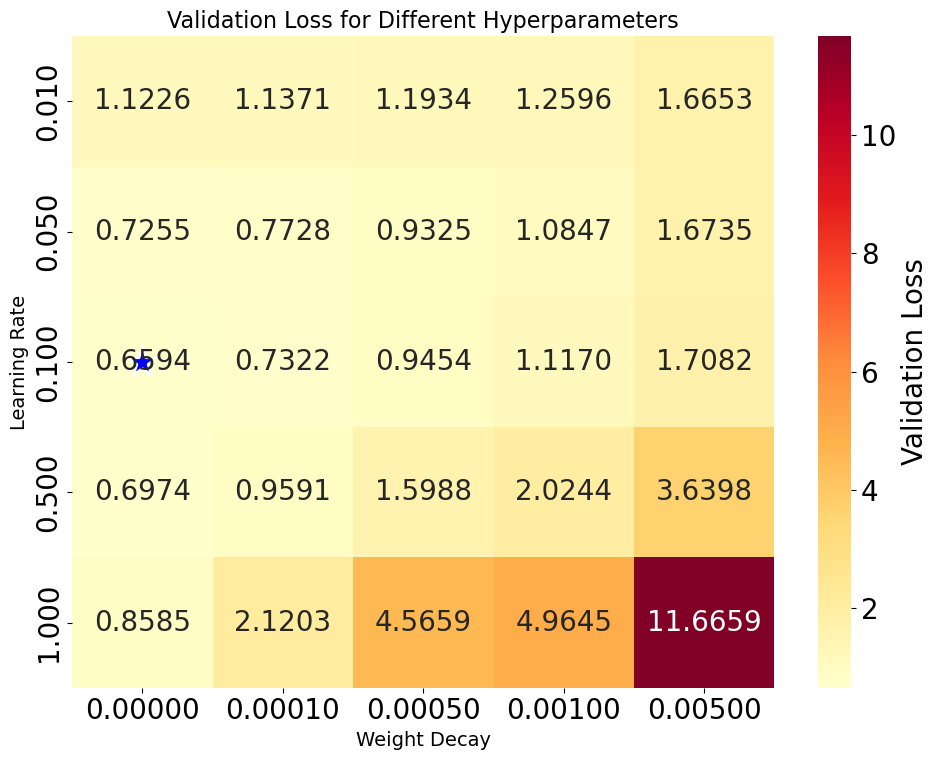


Training final model with optimal hyperparameters...
Epoch 10/150, Train Loss: 1.3318, Val Loss: 1.3502
Epoch 20/150, Train Loss: 0.9652, Val Loss: 1.0385
Epoch 30/150, Train Loss: 0.8134, Val Loss: 0.9239
Epoch 40/150, Train Loss: 0.7148, Val Loss: 0.8386
Epoch 50/150, Train Loss: 0.6518, Val Loss: 0.8235
Epoch 60/150, Train Loss: 0.6036, Val Loss: 0.7867
Epoch 70/150, Train Loss: 0.5632, Val Loss: 0.7414
Epoch 80/150, Train Loss: 0.5339, Val Loss: 0.7329
Epoch 90/150, Train Loss: 0.5016, Val Loss: 0.7104
Epoch 100/150, Train Loss: 0.4787, Val Loss: 0.7092
Epoch 110/150, Train Loss: 0.4588, Val Loss: 0.7030
Epoch 120/150, Train Loss: 0.4397, Val Loss: 0.6887
Epoch 130/150, Train Loss: 0.4220, Val Loss: 0.6808
Epoch 140/150, Train Loss: 0.4070, Val Loss: 0.6686
Epoch 150/150, Train Loss: 0.3926, Val Loss: 0.6594


In [76]:
# Create heatmap of validation losses
val_loss_matrix = np.zeros((len(learning_rates), len(weight_decays)))

for i, lr in enumerate(learning_rates):
    for j, wd in enumerate(weight_decays):
        val_loss_matrix[i, j] = results[(lr, wd)]['final_val_loss']

plt.figure(figsize=(10, 8))
sns.heatmap(val_loss_matrix, 
            xticklabels=[f'{wd:.5f}' for wd in weight_decays],
            yticklabels=[f'{lr:.3f}' for lr in learning_rates],
            annot=True, fmt='.4f', cmap='YlOrRd',
            cbar_kws={'label': 'Validation Loss'})

plt.xlabel('Weight Decay', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)
plt.title('Validation Loss for Different Hyperparameters', fontsize=16)

# Mark the best combination
best_lr_idx = learning_rates.index(best_params['learning_rate'])
best_wd_idx = weight_decays.index(best_params['weight_decay'])
plt.scatter(best_wd_idx + 0.5, best_lr_idx + 0.5, 
           marker='*', s=500, c='blue', edgecolor='white', linewidth=2)

plt.tight_layout()
plt.show()

# Train final model with best hyperparameters
print("\nTraining final model with optimal hyperparameters...")
W_final, train_hist_final, val_hist_final = train_multiclass_logistic_regression(
    X_train, y_train, X_val, y_val,
    num_classes=num_classes,
    num_epochs=150,
    batch_size=32,
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
    seed=42
)

The hyperparameter heatmap reveals that the best learning rate is 0.1 and the best weight decay is 0.0.

**Learning Rate Sensitivity**: Performance improves dramatically as learning rate increases from 0.01 to 0.1, with the optimal value at 0.1. However, further increases to 0.5 and 1.0 lead to degradation, suggesting we've found the sweet spot. The model benefits from aggressive optimization steps up to a point, after which instability sets in.

**Regularization Effects**: Weight decay consistently hurts performance across all learning rates, with the degradation becoming catastrophic at higher learning rates. This suggests that our embedding features are already well-regularized (coming from a pre-trained embedding model), and additional L2 penalties only constrain the model's ability to adapt to our specific classification task.



## Model Evaluation: Confusion Matrix and Accuracy

With our optimized model trained, we need to evaluate its performance comprehensively. A confusion matrix provides detailed insights into classification performance by showing exactly how our model confuses different classes.

For multi-class problems with many categories, the confusion matrix becomes particularly valuable. It reveals:
- Which classes are accurately identified
- Systematic confusion patterns between similar classes
- Whether certain classes dominate misclassifications

Let's compute and visualize the confusion matrix for our 50-class strong lensing classification problem:

## Understanding Classification Metrics

Beyond simple accuracy, several metrics provide deeper insights into classifier performance:

**Accuracy**: The fraction of correct predictions across all classes. While intuitive, accuracy can be misleading for imbalanced datasets where predicting the majority class yields high scores.

**Precision**: For each class, precision measures the fraction of predicted instances that truly belong to that class:
$$\text{Precision}_k = \frac{\text{True Positives}_k}{\text{True Positives}_k + \text{False Positives}_k}$$

High precision means that when the model predicts class $k$, it's usually correct. Low precision indicates many false alarms.

**Recall (Sensitivity)**: For each class, recall measures the fraction of true instances that were correctly identified:
$$\text{Recall}_k = \frac{\text{True Positives}_k}{\text{True Positives}_k + \text{False Negatives}_k}$$

High recall means the model finds most instances of class $k$. Low recall indicates the model misses many true instances.

**F1 Score**: The harmonic mean of precision and recall, providing a balanced measure:
$$\text{F1}_k = 2 \cdot \frac{\text{Precision}_k \cdot \text{Recall}_k}{\text{Precision}_k + \text{Recall}_k}$$

The F1 score reaches its maximum when precision and recall are both perfect, and decreases when either metric is poor. Unlike the arithmetic mean, the harmonic mean penalizes extreme imbalances between precision and recall.

For multi-class problems, we compute these metrics for each class separately, then average across classes. This per-class analysis reveals which object types are reliably identified versus those causing confusion.

In [77]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    """
    Compute confusion matrix from predictions.
    
    Parameters
    ----------
    y_true : np.ndarray
        True class labels
    y_pred : np.ndarray
        Predicted class labels
    num_classes : int
        Number of classes
        
    Returns
    -------
    np.ndarray
        Confusion matrix of shape (num_classes, num_classes)
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    
    return cm


def calculate_metrics(cm):
    """
    Calculate various metrics from confusion matrix.
    
    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
        
    Returns
    -------
    dict
        Dictionary containing various metrics
    """
    # Overall accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Per-class metrics
    num_classes = len(cm)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    
    for i in range(num_classes):
        # True positives
        tp = cm[i, i]
        
        # False positives (predicted as i but actually other classes)
        fp = np.sum(cm[:, i]) - tp
        
        # False negatives (actually i but predicted as other classes)
        fn = np.sum(cm[i, :]) - tp
        
        # Calculate metrics
        if tp + fp > 0:
            precision[i] = tp / (tp + fp)
        if tp + fn > 0:
            recall[i] = tp / (tp + fn)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_precision': np.mean(precision),
        'avg_recall': np.mean(recall),
        'avg_f1': np.mean(f1_score)
    }


# Make predictions on validation set
y_val_pred = predict_classes(X_val, W_final)

# Compute confusion matrix
cm = compute_confusion_matrix(y_val, y_val_pred, num_classes)

# Calculate metrics
metrics = calculate_metrics(cm)

print("Classification Metrics:")
print("-" * 50)
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Average Precision: {metrics['avg_precision']:.4f}")
print(f"Average Recall: {metrics['avg_recall']:.4f}")
print(f"Average F1-Score: {metrics['avg_f1']:.4f}")

Classification Metrics:
--------------------------------------------------
Overall Accuracy: 0.7809
Average Precision: 0.8094
Average Recall: 0.7817
Average F1-Score: 0.7824


Generating confusion matrix visualization...
Note: Diagonal elements show correct predictions


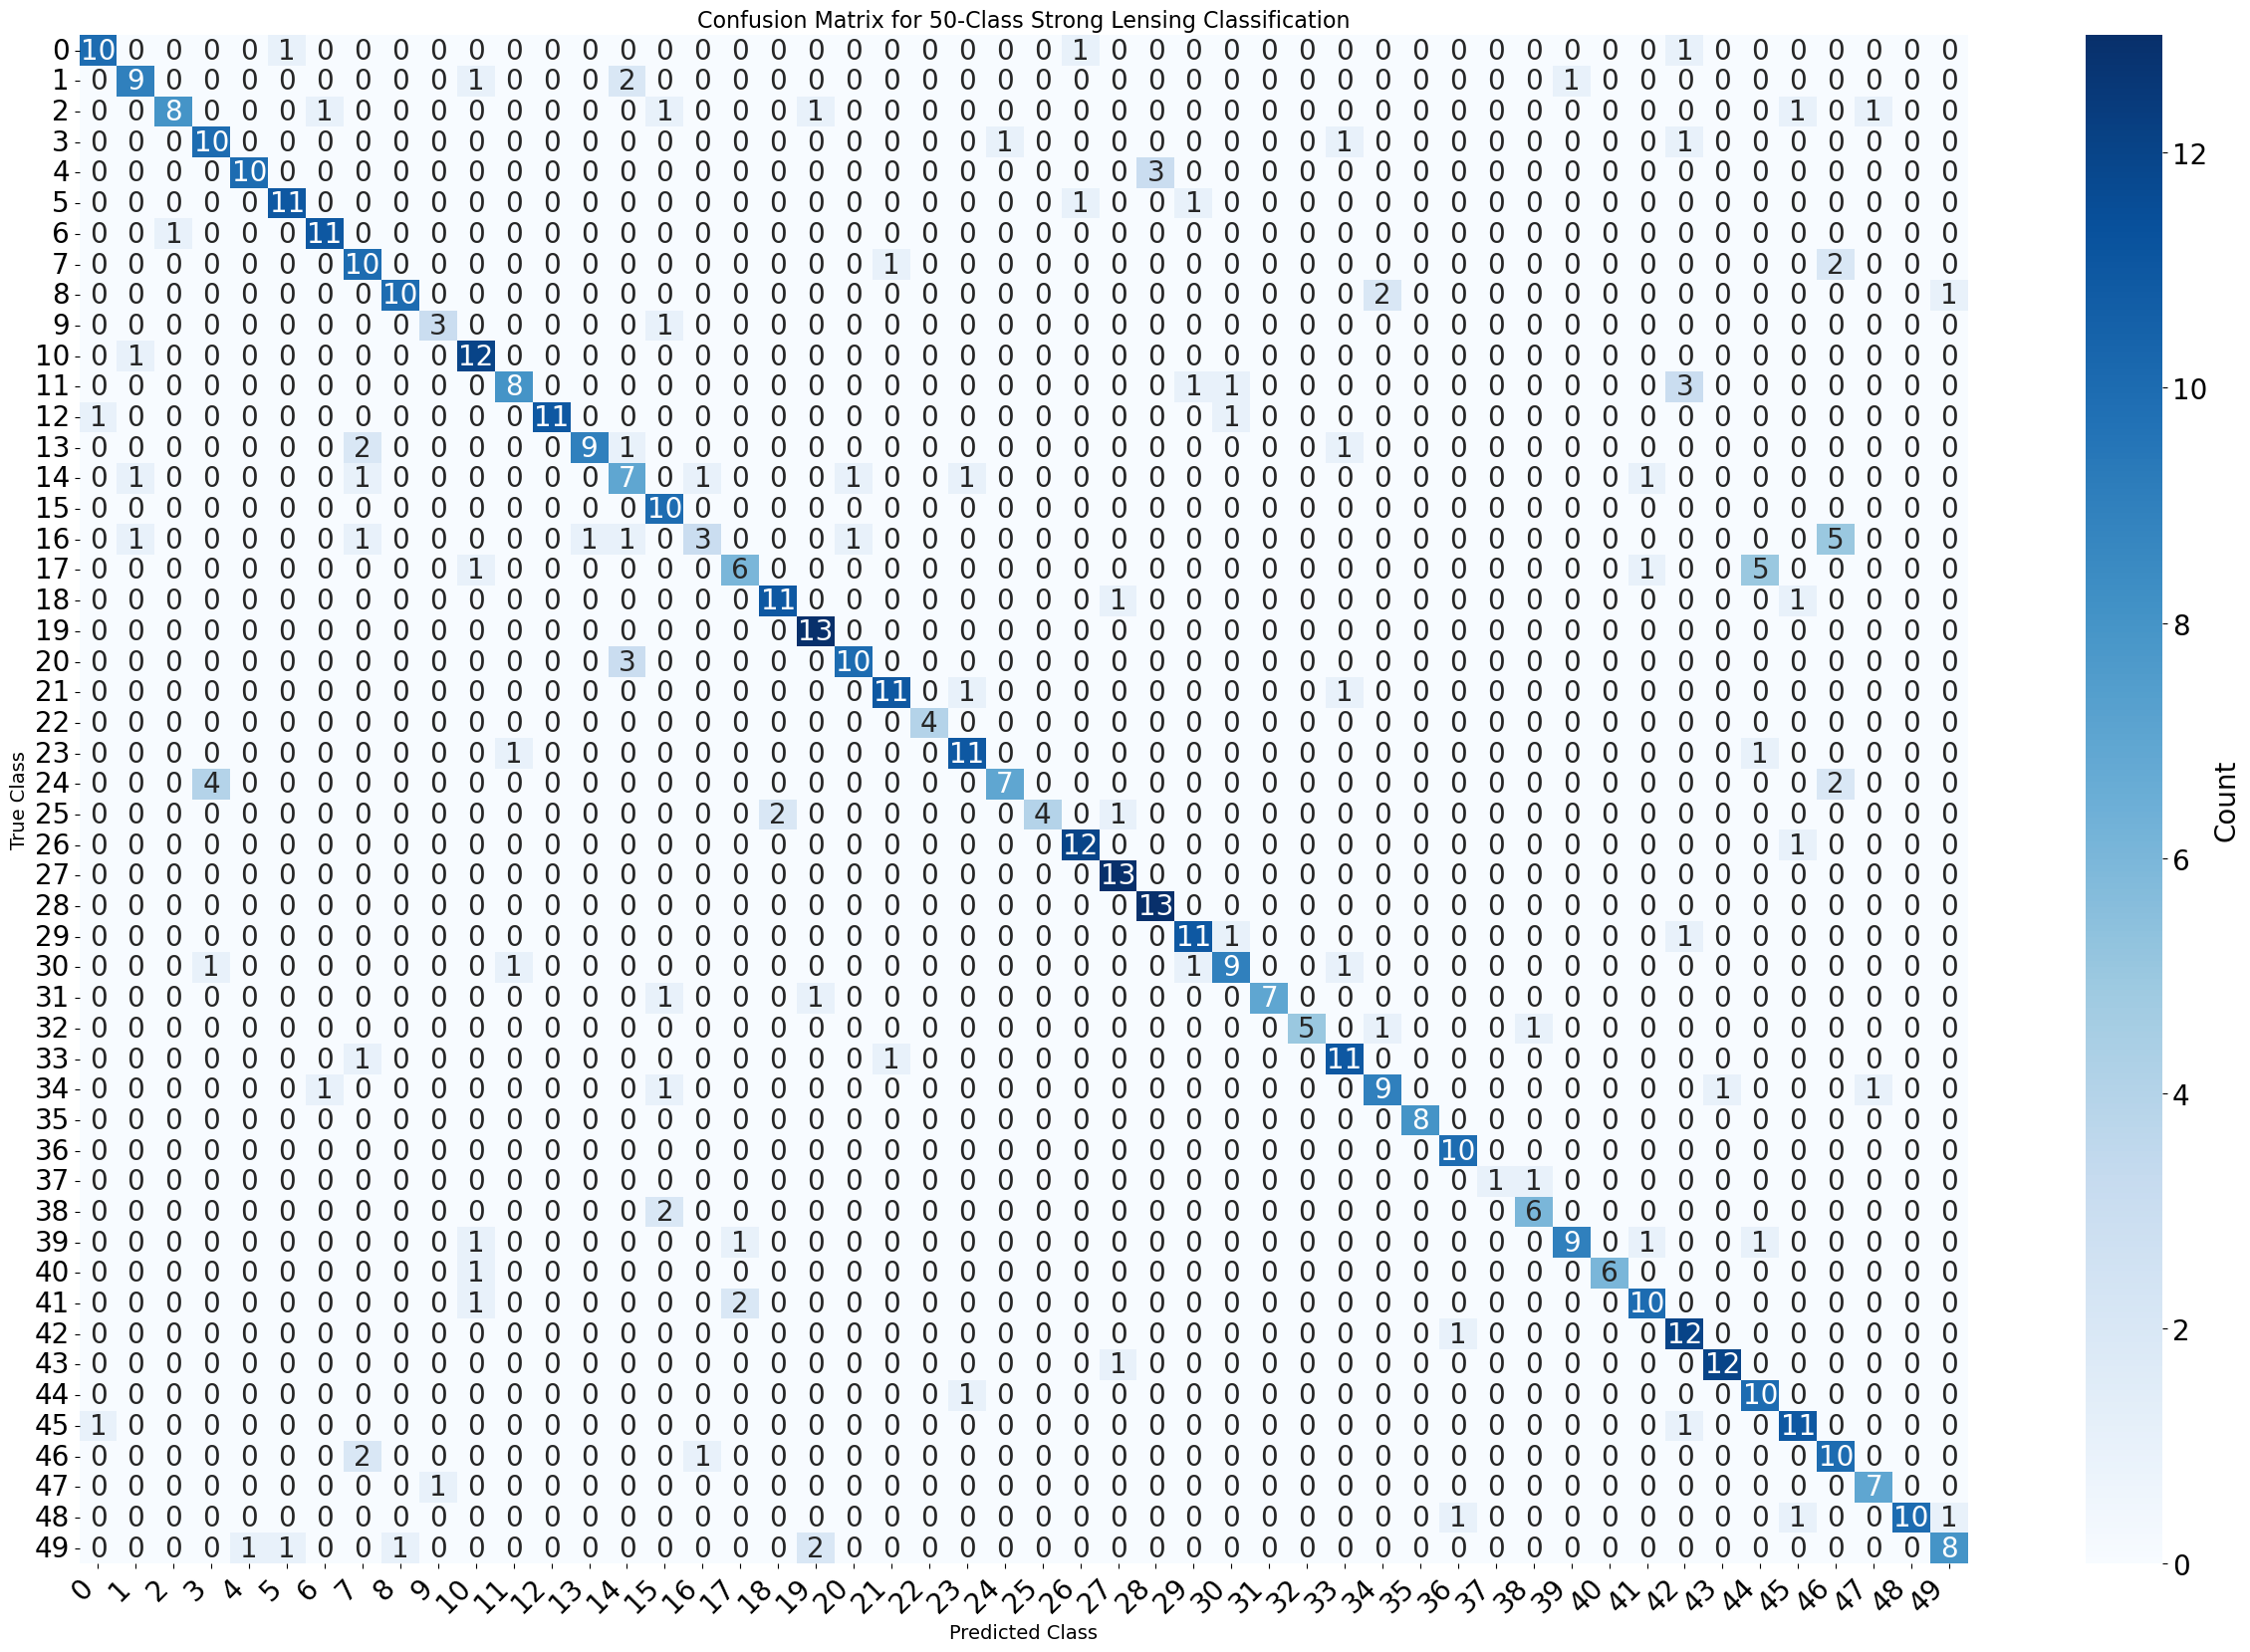

In [78]:
def plot_confusion_matrix(cm, class_names=None, figsize=(25, 17)):
    """
    Create a detailed visualization of the confusion matrix.
    
    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
    class_names : list
        Names for each class
    figsize : tuple
        Figure size
    """
    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]
    
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.xlabel('Predicted Class', fontsize=14)
    plt.ylabel('True Class', fontsize=14)
    plt.title('Confusion Matrix for 50-Class Strong Lensing Classification', fontsize=16)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Create class names
class_names = [str(c) for c in unique_clusters]

# Plot confusion matrix
print("Generating confusion matrix visualization...")
print("Note: Diagonal elements show correct predictions")
plot_confusion_matrix(cm, class_names)

## Understanding Classification Errors

The confusion matrix reveals which classes our model struggles to distinguish. By analyzing the most common misclassifications, we can gain insights into the limitations of our feature representation and identify opportunities for improvement.

Examining the confusion matrix, we observe:
- Strong diagonal dominance indicates good overall performance
- Off-diagonal elements reveal systematic confusion patterns
- Some classes show nearly perfect classification while others have substantial errors

Let's identify the worst-performing classes and examine what they're being confused with:


In [79]:
def analyze_worst_performing_classes(cm, class_names, dataframe, n_worst=3):
    """
    Identify and visualize the worst-performing classes.
    
    Parameters
    ----------
    cm : np.ndarray
        Confusion matrix
    class_names : list
        Class names
    dataframe : pd.DataFrame
        Original dataframe with images and metadata
    n_worst : int
        Number of worst classes to analyze
    """
    # Calculate per-class accuracy
    per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    
    # Find worst performing classes
    worst_indices = np.argsort(per_class_accuracy)[:n_worst]
    
    print("Worst Performing Classes:")
    print("-" * 60)
    
    worst_pairs = []
    
    for rank, idx in enumerate(worst_indices):
        accuracy = per_class_accuracy[idx]
        class_name = class_names[idx]
        
        # Find what this class is most confused with
        confusion_row = cm[idx].copy()
        confusion_row[idx] = 0  # Exclude correct predictions
        most_confused_idx = np.argmax(confusion_row)
        confusion_count = confusion_row[most_confused_idx]
        
        print(f"\nRank {rank+1} worst: Class {class_name}")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Most confused with: Class {class_names[most_confused_idx]} ({confusion_count} times)")
        
        # Get descriptions if available
        class_desc = dataframe[dataframe['cluster'] == int(class_name)].iloc[0]['concise_description']
        confused_desc = dataframe[dataframe['cluster'] == int(class_names[most_confused_idx])].iloc[0]['concise_description']
        
        print(f"  Description: {class_desc}")
        print(f"  Confused with: {confused_desc}")
        
        worst_pairs.append((int(class_name), int(class_names[most_confused_idx])))
    
    return worst_pairs

# Analyze worst performing classes
worst_pairs = analyze_worst_performing_classes(cm, class_names, images_df, n_worst=3)

Worst Performing Classes:
------------------------------------------------------------

Rank 1 worst: Class 16
  Accuracy: 0.231
  Most confused with: Class 46 (5 times)
  Description: Colorful, blurry nebulous structures with blue-orange contrast
  Confused with: Extremely blurry, low-resolution red-blue color patches

Rank 2 worst: Class 17
  Accuracy: 0.462
  Most confused with: Class 44 (5 times)
  Description: Diffuse colorful background regions without distinct objects
  Confused with: Blurry color gradients with no distinct astronomical objects

Rank 3 worst: Class 37
  Accuracy: 0.500
  Most confused with: Class 38 (1 times)
  Description: Elongated arcs with blue-pink coloration
  Confused with: Elongated arc-like structures with blue-purple coloration



Visual Comparison of Confused Classes:


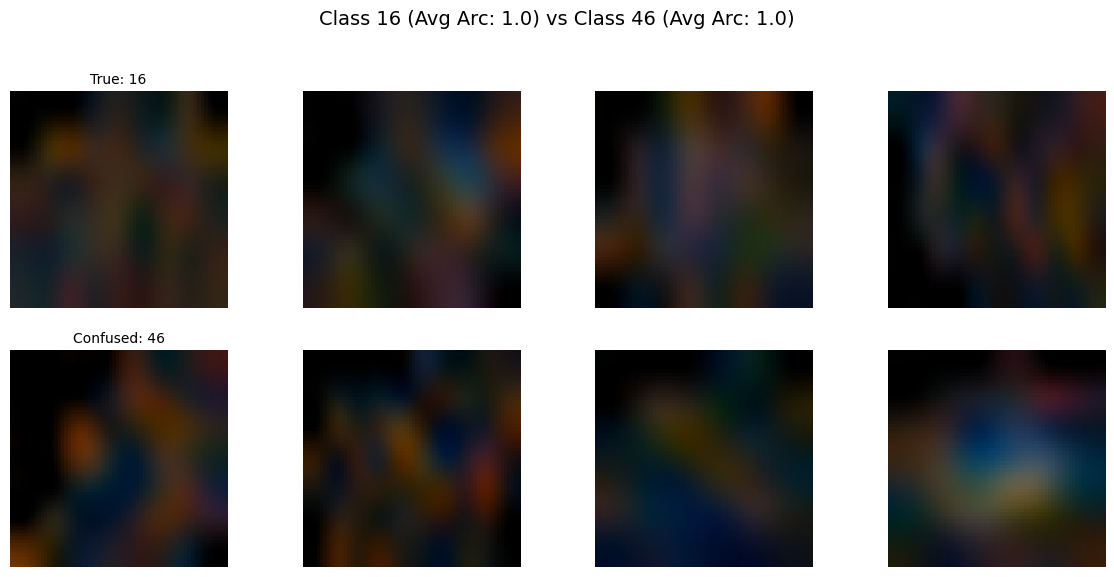

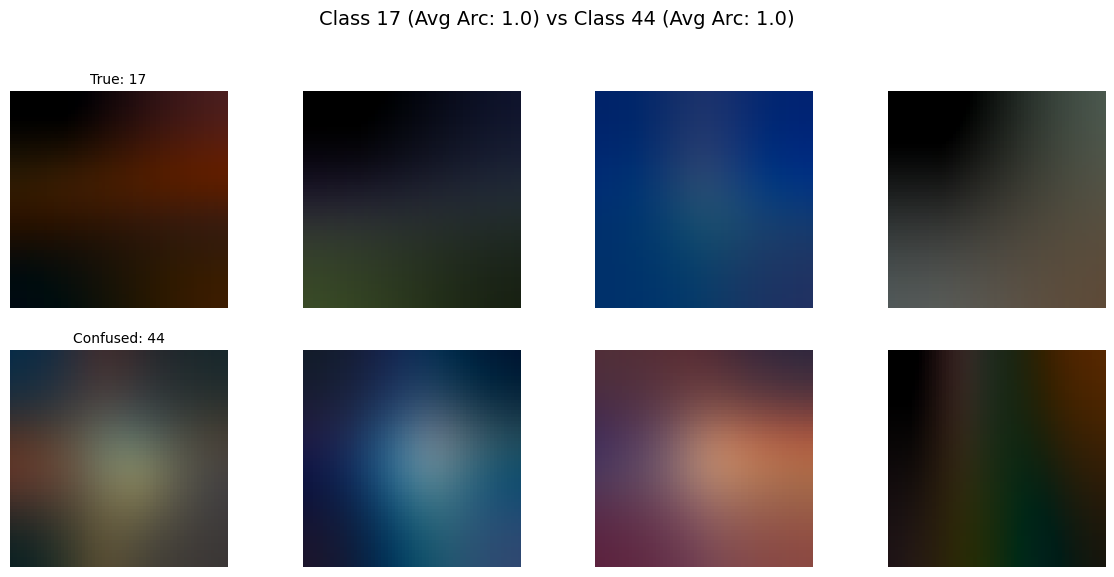

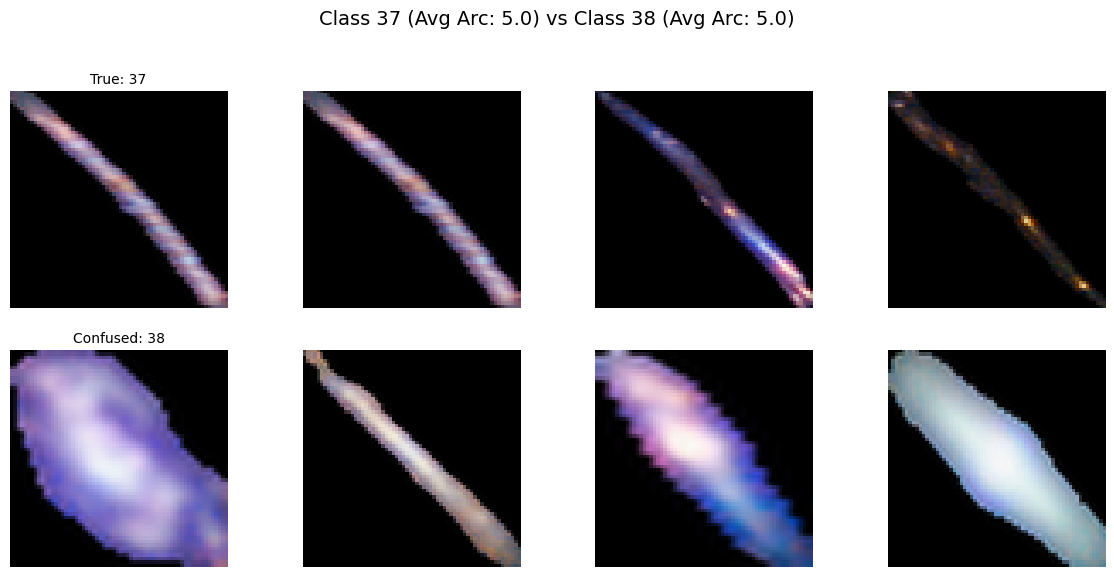

In [80]:
def visualize_confusion_pairs(dataframe, confusion_pairs, n_examples=3):
    """
    Visualize examples from confused class pairs.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Dataset with images
    confusion_pairs : list
        List of (true_class, confused_class) tuples
    n_examples : int
        Number of examples per class
    """
    # Make a copy and ensure arc ratings are numeric
    df_work = dataframe.copy()
    df_work['contains_gravitational_arcs'] = pd.to_numeric(
        df_work['contains_gravitational_arcs'], 
        errors='coerce'
    )
    
    for true_class, confused_class in confusion_pairs:
        # Get examples
        true_examples = df_work[df_work['cluster'] == true_class].sample(
            min(n_examples, len(df_work[df_work['cluster'] == true_class]))
        )
        confused_examples = df_work[df_work['cluster'] == confused_class].sample(
            min(n_examples, len(df_work[df_work['cluster'] == confused_class]))
        )
        
        # Create figure
        fig, axes = plt.subplots(2, n_examples, figsize=(n_examples*3, 6))
        if n_examples == 1:
            axes = axes.reshape(2, 1)
        
        # Get average arc ratings
        true_avg_arc = true_examples['contains_gravitational_arcs'].dropna().mean()
        confused_avg_arc = confused_examples['contains_gravitational_arcs'].dropna().mean()
        
        # Format title with arc ratings if available
        title_parts = [f'Class {true_class}']
        if pd.notna(true_avg_arc):
            title_parts.append(f'(Avg Arc: {true_avg_arc:.1f})')
        title_parts.append(f'vs Class {confused_class}')
        if pd.notna(confused_avg_arc):
            title_parts.append(f'(Avg Arc: {confused_avg_arc:.1f})')
            
        fig.suptitle(' '.join(title_parts), fontsize=14)
        
        # Display true class examples
        for i, (_, row) in enumerate(true_examples.iterrows()):
            if i < n_examples:
                axes[0, i].imshow(row['image_resized'])
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_title(f'True: {true_class}', fontsize=10)
        
        # Display confused class examples
        for i, (_, row) in enumerate(confused_examples.iterrows()):
            if i < n_examples:
                axes[1, i].imshow(row['image_resized'])
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_title(f'Confused: {confused_class}', fontsize=10)
        
        plt.tight_layout()
        plt.show()


# Visualize confusion examples
print("\nVisual Comparison of Confused Classes:")
print("=" * 60)
visualize_confusion_pairs(images_df, worst_pairs, n_examples=4)

### Insights from Misclassification Patterns

The visual comparison reveals nuanced insights into our model's performance across different types of confusion cases. The misclassification patterns fall into two distinct categories that highlight different aspects of the classification challenge.

**Legitimately Difficult Cases**: The first two confusion pairs (Classes 16 vs 46 and 17 vs 44) show objects that even human experts would struggle to distinguish reliably. These feature very low-contrast, diffuse structures with subtle color variations - exactly the type of ambiguous cases where disagreement between annotators is common. Both confused pairs have identical average arc ratings (1.0), indicating objects without clear gravitational lensing features. The model's confusion here reflects genuine ambiguity in the data rather than a failure of the approach.

**Distinguishable Morphological Variations**: The third confusion pair (Classes 37 vs 38) presents a more intriguing case. While both classes have identical average arc ratings (5.0), indicating definite gravitational arcs, the visual differences are apparent to human observers. Class 37 consistently shows thin, linear gravitational arcs, while Class 38 displays broader, more curved or blob-like lensing structures. These represent different morphological subtypes of strong gravitational lensing that carry distinct astrophysical information about the lens mass distribution and source geometry.

**Feature Representation Gaps**: The confusion between clearly distinguishable lensing morphologies (Classes 37 vs 38) suggests that our pre-trained CLIP embeddings, while capturing the general presence of gravitational arcs, may not encode the subtle geometric features that distinguish different arc morphologies. Key features that astronomers recognize—such as arc curvature radius, aspect ratio, or the presence of multiple images versus extended arcs—may not be well-represented in embeddings trained primarily on everyday photographs.

**Linear Model Limitations**: Logistic regression assumes linear separability in feature space. While our 512-dimensional embeddings provide rich representations, the linear decision boundaries may be insufficient for capturing the complex relationships needed to distinguish between morphologically similar but scientifically distinct lensing configurations.

**The Domain Adaptation Challenge**: This analysis highlights the nuanced challenge of domain adaptation. The pre-trained model successfully captures the fundamental distinction between lensed and non-lensed objects, as evidenced by the strong correlation between embeddings and arc ratings. However, fine-grained morphological distinctions within the lensing category require more specialized representations that may benefit from astronomical domain knowledge.

**Validation of the Approach**: Importantly, the model's confusion between objects with similar arc ratings actually validates our feature extraction approach. Rather than making arbitrary visual distinctions, the embeddings group objects by their fundamental astrophysical properties. The confusion between legitimately ambiguous cases (low-contrast diffuse objects) demonstrates appropriate uncertainty handling, while the grouping of different lensing morphologies suggests the model recognizes their shared physical nature as gravitational lensing phenomena.

This pattern suggests that while our model occasionally struggles with fine-grained morphological distinctions, the embeddings successfully capture the presence or absence of lensing features at a fundamental level. For many astronomical applications, correctly identifying the presence of strong lensing may be more important than distinguishing between subtle morphological variations, making this a reasonable trade-off for an automated classification system.

## Summary

This tutorial extended binary logistic regression from Chapter 7 to handle multi-class classification problems. Through classifying JWST strong lensing images into 50 categories, we implemented the key concepts from Chapter 8 of the textbook.

Multi-class classification is essential for astronomical applications where phenomena naturally fall into multiple categories rather than binary divisions. In our strong lensing example, different arc morphologies, Einstein rings, and multiply-imaged systems each represent distinct physical configurations that cannot be captured by simple yes/no classifications. This multiplicity appears throughout astronomy: stellar spectral types (O, B, A, F, G, K, M), galaxy morphologies (elliptical, spiral, irregular), and transient classifications (various supernova types, variable star classes). The ability to distinguish among many categories enables more nuanced scientific analysis and targeted follow-up observations.

Key implementations from this tutorial:

- **Softmax Function**: Implemented the numerically stable version using the log-sum-exp trick to prevent overflow, generalizing the sigmoid function to multiple classes.

- **Multi-class Cross-Entropy Loss**: Extended binary cross-entropy to $K$ classes using efficient matrix operations.

- **Gradient Computation**: Verified that multi-class gradients maintain the same form as binary classification: $\nabla_{\mathbf{W}} E = \frac{1}{N}\mathbf{X}^T(\mathbf{Y} - \mathbf{T})$.

- **Mini-batch SGD**: Implemented stochastic gradient descent with variable batch sizes and learning rates.

- **Hyperparameter Optimization**: Explored the interaction between learning rate and regularization strength through grid search.

- **Model Evaluation**: Computed confusion matrices and per-class metrics to understand classification performance beyond simple accuracy.

This framework extends directly to any multi-class astronomical classification task, providing a computationally efficient and interpretable baseline approach.